# The Insurance Problem
As a customer shops an insurance policy, he/she will receive a number of quotes with different coverage options before purchasing a plan. Is it possible predict the purchased coverage options using a limited subset of the total interaction history? If the eventual purchase can be predicted sooner in the shopping window, the quoting process is shortened and the issuer is less likely to lose the customer's business.

Using a customer’s shopping history, can you predict what policy they will end up choosing?

### Essential Libraries

Let us begin by importing the essential Python Libraries.

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import chi2_contingency
from scipy.stats import chi2
sb.set()

### Dataset Source:
Dataset from Kaggle : **"Allstate Purchase Prediction Challenge"** by *Allstate Insurance*  
Source: https://www.kaggle.com/c/allstate-purchase-prediction-challenge/data (requires login)

In [2]:
data = pd.read_csv("Insurance.csv")

In [3]:
data.shape

(665249, 25)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665249 entries, 0 to 665248
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_ID        665249 non-null  int64  
 1   shopping_pt        665249 non-null  int64  
 2   record_type        665249 non-null  int64  
 3   day                665249 non-null  int64  
 4   time               665249 non-null  object 
 5   state              665249 non-null  object 
 6   location           665249 non-null  int64  
 7   group_size         665249 non-null  int64  
 8   homeowner          665249 non-null  int64  
 9   car_age            665249 non-null  int64  
 10  car_value          663718 non-null  object 
 11  risk_factor        424831 non-null  float64
 12  age_oldest         665249 non-null  int64  
 13  age_youngest       665249 non-null  int64  
 14  married_couple     665249 non-null  int64  
 15  C_previous         646538 non-null  float64
 16  du

In [5]:
data.head(n=7)

,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
0,10000000,1,0,0,08:35,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,2,633
1,10000000,2,0,0,08:38,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
2,10000000,3,0,0,08:38,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
3,10000000,4,0,0,08:39,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
4,10000000,5,0,0,11:55,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,630
5,10000000,6,0,0,11:57,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,638
6,10000000,7,0,0,11:58,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,1,638


---
# Data Cleaning

We observe that we have large number of NAN values in risk_factor column. By both Domain Knowledge and some EDA later on, we'll find that riskfactor is a very important variable in determining what policy the customer will be purchasing and what the cost of that policy will be. Additionally, it would be wrong to blindly fill in the missing values with the median as that will dilute the relationship of the risk_factor with other variables. Here, we have opted to simply drop all NAN riskfactor values as they impose no bias and we still have a large number of records to work with.

Next, we reset the index the dataset to convert it into something we can work on for now. We'll use other data cleaning techniques like variable encoding and resampling later on.

In [6]:
data.dropna(subset=["car_value","C_previous","duration_previous","risk_factor"],inplace=True)

In [7]:
data.reset_index(inplace=True)

In [8]:
data.shape

(417447, 26)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417447 entries, 0 to 417446
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              417447 non-null  int64  
 1   customer_ID        417447 non-null  int64  
 2   shopping_pt        417447 non-null  int64  
 3   record_type        417447 non-null  int64  
 4   day                417447 non-null  int64  
 5   time               417447 non-null  object 
 6   state              417447 non-null  object 
 7   location           417447 non-null  int64  
 8   group_size         417447 non-null  int64  
 9   homeowner          417447 non-null  int64  
 10  car_age            417447 non-null  int64  
 11  car_value          417447 non-null  object 
 12  risk_factor        417447 non-null  float64
 13  age_oldest         417447 non-null  int64  
 14  age_youngest       417447 non-null  int64  
 15  married_couple     417447 non-null  int64  
 16  C_

---
# Exploratory Data Analysis

Let's look at some interesting relationships between the varaibles in the dataset. We begin by checking the datatypes of all the columns

In [10]:
data.dtypes

index                  int64
customer_ID            int64
shopping_pt            int64
record_type            int64
day                    int64
time                  object
state                 object
location               int64
group_size             int64
homeowner              int64
car_age                int64
car_value             object
risk_factor          float64
age_oldest             int64
age_youngest           int64
married_couple         int64
C_previous           float64
duration_previous    float64
A                      int64
B                      int64
C                      int64
D                      int64
E                      int64
F                      int64
G                      int64
cost                   int64
dtype: object

In [11]:
data.describe()

,index,customer_ID,shopping_pt,record_type,day,location,group_size,homeowner,car_age,risk_factor,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
count,417447.000000,4.174470e+05,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,...,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000,417447.000000
mean,332887.747724,1.007661e+07,4.267471,0.149133,1.948587,12275.645248,1.249184,0.594186,7.717696,2.559003,...,2.596406,6.679780,0.954928,0.466493,2.451794,2.570264,0.490225,1.101584,2.404138,632.695010
std,191966.245071,4.403242e+04,2.397240,0.356220,1.452714,1552.833289,0.470781,0.491050,5.637517,1.112997,...,1.007123,4.825717,0.568967,0.498877,0.973004,0.684091,0.499905,0.933465,0.901338,46.219299
min,0.000000,1.000000e+07,1.000000,0.000000,0.000000,10001.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,260.000000
25%,166567.500000,1.003858e+07,2.000000,0.000000,1.000000,10965.000000,1.000000,0.000000,3.000000,2.000000,...,2.000000,3.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,2.000000,601.000000
50%,332444.000000,1.007637e+07,4.000000,0.000000,2.000000,12037.000000,1.000000,1.000000,7.000000,3.000000,...,3.000000,6.000000,1.000000,0.000000,3.000000,3.000000,0.000000,1.000000,2.000000,631.000000
75%,499785.500000,1.011489e+07,6.000000,0.000000,3.000000,13427.000000,1.000000,1.000000,11.000000,4.000000,...,3.000000,10.000000,1.000000,1.000000,3.000000,3.000000,1.000000,2.000000,3.000000,662.000000
max,665242.000000,1.015272e+07,13.000000,1.000000,6.000000,16580.000000,4.000000,1.000000,85.000000,4.000000,...,4.000000,15.000000,2.000000,1.000000,4.000000,3.000000,1.000000,3.000000,4.000000,911.000000


#### How many times does a customer visit the Insurance website on an average before purchasing a policy?

In [12]:
data[data.customer_ID == 10000000]

,index,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
0,0,10000000,1,0,0,08:35,IN,10001,2,0,...,1.0,2.0,1,0,2,2,1,2,2,633
1,1,10000000,2,0,0,08:38,IN,10001,2,0,...,1.0,2.0,1,0,2,2,1,2,1,630
2,2,10000000,3,0,0,08:38,IN,10001,2,0,...,1.0,2.0,1,0,2,2,1,2,1,630
3,3,10000000,4,0,0,08:39,IN,10001,2,0,...,1.0,2.0,1,0,2,2,1,2,1,630
4,4,10000000,5,0,0,11:55,IN,10001,2,0,...,1.0,2.0,1,0,2,2,1,2,1,630
5,5,10000000,6,0,0,11:57,IN,10001,2,0,...,1.0,2.0,1,0,2,2,1,2,1,638
6,6,10000000,7,0,0,11:58,IN,10001,2,0,...,1.0,2.0,1,0,2,2,1,2,1,638
7,7,10000000,8,0,0,12:03,IN,10001,2,0,...,1.0,2.0,1,0,2,2,1,2,1,638
8,8,10000000,9,1,0,12:07,IN,10001,2,0,...,1.0,2.0,1,0,2,2,1,2,1,634


In [13]:
test = data.groupby("customer_ID").max()

In [14]:
type(test)

pandas.core.frame.DataFrame

In [15]:
test

,index,shopping_pt,record_type,day,time,state,location,group_size,homeowner,car_age,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
customer_ID,,,,,,,,,,,,,,,,,,,,,
10000000,8,9,1,0,12:07,IN,10001,2,0,2,...,1.0,2.0,1,0,2,2,1,2,2,638
10000005,14,6,1,3,09:09,NY,10006,1,0,10,...,3.0,13.0,1,1,3,3,1,0,2,755
10000013,26,4,1,4,16:36,WV,10014,2,1,3,...,3.0,3.0,1,1,3,2,1,2,3,629
10000014,32,6,1,4,17:50,MO,10015,1,0,5,...,1.0,2.0,2,1,3,3,0,2,2,614
10000023,57,7,1,1,14:32,PA,10025,2,1,2,...,1.0,13.0,1,1,3,3,1,1,2,659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10152713,665204,9,1,2,09:23,FL,11722,1,1,7,...,1.0,15.0,1,1,2,3,1,1,3,671
10152717,665216,7,1,2,09:24,MD,10441,1,1,1,...,3.0,4.0,1,1,3,3,1,2,2,713
10152718,665225,9,1,2,10:36,FL,11018,2,1,1,...,4.0,15.0,2,1,4,3,1,3,4,628


In [16]:
test.shape

(62978, 25)

In [17]:
data[data.record_type==1]

,index,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
8,8,10000000,9,1,0,12:07,IN,10001,2,0,...,1.0,2.0,1,0,2,2,1,2,1,634
14,14,10000005,6,1,3,09:09,NY,10006,1,0,...,3.0,13.0,0,0,3,2,0,0,2,731
18,26,10000013,4,1,4,09:31,WV,10014,2,1,...,3.0,3.0,1,1,3,2,1,1,3,626
24,32,10000014,6,1,1,17:50,MO,10015,1,0,...,1.0,2.0,1,1,1,1,0,2,2,614
31,57,10000023,7,1,1,14:32,PA,10025,1,1,...,1.0,13.0,1,1,1,3,1,1,2,607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417420,665204,10152713,9,1,2,09:23,FL,11722,1,1,...,1.0,15.0,1,0,1,3,1,1,3,663
417427,665216,10152717,7,1,2,09:24,MD,10441,1,1,...,3.0,4.0,1,1,3,2,1,2,1,674
417436,665225,10152718,9,1,2,10:36,FL,11018,2,1,...,4.0,15.0,1,1,4,3,1,2,4,628
417443,665233,10152720,8,1,4,08:34,FL,14100,1,0,...,1.0,8.0,1,0,1,2,0,2,3,681


In [18]:
data[data.record_type==1].shape

(62255, 26)

In [19]:
test.shopping_pt.median()

7.0

So, an average customer who purchases a policy in the end takes a week to make up his/her mind

In [20]:
data.car_value.unique()

array(['g', 'e', 'd', 'f', 'c', 'h', 'i', 'b', 'a'], dtype=object)

Cars can be calassified into 10 different types based on their value when they were new.

In [21]:
data.risk_factor.unique() 

array([3., 4., 2., 1.])

risk_factor is a categorical variable with risk_factor=1 implying low risk and risk_factor=4 implying high risk

In [22]:
data.location.unique()

array([10001, 10006, 10014, ..., 16579, 16562, 16580])

Location of the customer in terms of some arbitary identification code chosen by AllState Insurance

In [23]:
data.car_age.unique()

array([ 2, 10,  3,  5, 15, 17,  1, 12,  8, 26,  9,  6,  7,  4, 11, 13, 19,
       14, 18, 16, 28, 24,  0, 23, 42, 22, 31, 27, 45, 20, 21, 25, 37, 38,
       41, 30, 59, 33, 58, 29, 46, 36, 34, 57, 40, 39, 32, 44, 43, 35, 61,
       74, 48, 47, 50, 64, 75, 55, 49, 62, 53, 85, 52, 60, 51, 65])

The age of the customer's car in years

In [24]:
data.homeowner.unique()

array([0, 1])

Whether the customer is a homeowner(1) or not(0)

In [25]:
data.C_previous.unique()

array([1., 3., 2., 4.])

The previous configuration of option C in the insurance policy

In [26]:
data.duration_previous.unique()

array([ 2., 13.,  3.,  0.,  1., 14.,  5., 15.,  4.,  6., 11.,  9., 10.,
        8.,  7., 12.])

The number of years the customer was covered by the previous insurance company

In [27]:
data[data['record_type']==1]

,index,customer_ID,shopping_pt,record_type,day,time,state,location,group_size,homeowner,...,C_previous,duration_previous,A,B,C,D,E,F,G,cost
8,8,10000000,9,1,0,12:07,IN,10001,2,0,...,1.0,2.0,1,0,2,2,1,2,1,634
14,14,10000005,6,1,3,09:09,NY,10006,1,0,...,3.0,13.0,0,0,3,2,0,0,2,731
18,26,10000013,4,1,4,09:31,WV,10014,2,1,...,3.0,3.0,1,1,3,2,1,1,3,626
24,32,10000014,6,1,1,17:50,MO,10015,1,0,...,1.0,2.0,1,1,1,1,0,2,2,614
31,57,10000023,7,1,1,14:32,PA,10025,1,1,...,1.0,13.0,1,1,1,3,1,1,2,607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417420,665204,10152713,9,1,2,09:23,FL,11722,1,1,...,1.0,15.0,1,0,1,3,1,1,3,663
417427,665216,10152717,7,1,2,09:24,MD,10441,1,1,...,3.0,4.0,1,1,3,2,1,2,1,674
417436,665225,10152718,9,1,2,10:36,FL,11018,2,1,...,4.0,15.0,1,1,4,3,1,2,4,628
417443,665233,10152720,8,1,4,08:34,FL,14100,1,0,...,1.0,8.0,1,0,1,2,0,2,3,681


In [28]:
data[data['record_type']==1].nunique()

index                62255
customer_ID          62255
shopping_pt             11
record_type              1
day                      7
time                   968
state                   36
location              5820
group_size               4
homeowner                2
car_age                 64
car_value                9
risk_factor              4
age_oldest              58
age_youngest            60
married_couple           2
C_previous               4
duration_previous       16
A                        3
B                        2
C                        4
D                        3
E                        2
F                        4
G                        4
cost                   345
dtype: int64

So, every customer purchases a policy only at the end of some n viewings. There is no customer in the dataframe that did not purchase a policy in the end, i.e, the dataframe is a collection of customer viewing points that resulted in a purchase.

In [29]:
test.shopping_pt.mean()

6.819444885515577

In [30]:
test.shopping_pt.median()

7.0

So, an average customer who purchases a policy in the end takes a week to make up his/her mind

#### Is there any bias in the number of policies purchased on the day of the week? If so, which day produces the highest purchase?

In [31]:
data[data['record_type']==1].day.value_counts()

4    12920
1    12420
2    12218
0    12197
3    11488
5      934
6       78
Name: day, dtype: int64

In [32]:
data[data['record_type']==1].day.value_counts().sum()

62255

In [33]:
data[data['record_type']==1].day.mean()

2.058276443659144

In [34]:
data[data['record_type']==1].day.median()

2.0

0    77829
1    73930
2    71665
3    64820
4    61803
5     4508
6      637
Name: day, dtype: int64


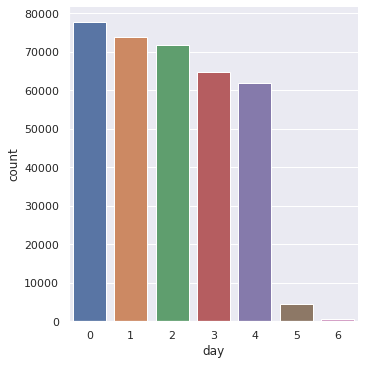

In [35]:
print(data[data['record_type']==0]['day'].value_counts())
sb.catplot(x = "day", data = data[data['record_type']==0], kind = "count")

From this we can infer that the policies received few views on weekends and the highest amount of views is on Monday, decreasing gradually through the week.

4    12920
1    12420
2    12218
0    12197
3    11488
5      934
6       78
Name: day, dtype: int64


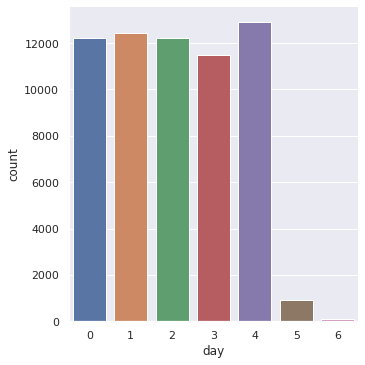

In [36]:
print(data[data['record_type']==1]['day'].value_counts())
sb.catplot(x = "day", data = data[data['record_type']==1], kind = "count")

From this we see that customers usually end up purchasing policies on weekdays with the highest number of purchases being on Friday. Few purchases are made on weekends.
This could possibly mean people start to look for policies on Mondays, and then takes a few days before buying them.

#### Which region, on the basis of the variable state, produced the highest purchase?

In [37]:
data.record_type.value_counts()

0    355192
1     62255
Name: record_type, dtype: int64

FL    89170
NY    75760
MD    23357
PA    22218
IN    20049
OH    13234
WA    11168
CO     9290
AL     8324
OR     6616
TN     6080
CT     6050
NV     5364
ID     4868
UT     4768
MO     4699
KY     4449
OK     4026
WI     3590
GA     3532
DE     3378
MS     2888
NH     2778
AR     2670
RI     2618
NM     2543
KS     2044
ME     1907
WV     1760
IA     1430
NE     1340
MT     1280
DC      916
WY      480
ND      376
SD      172
Name: state, dtype: int64


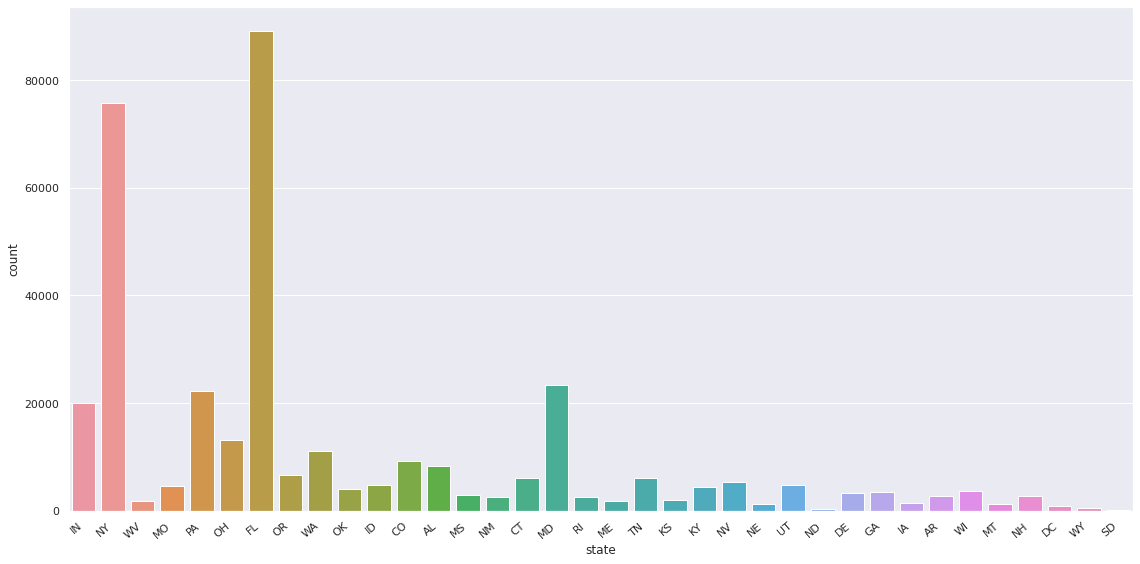

In [38]:
print(data[data['record_type']==0]['state'].value_counts())
f = plt.figure(figsize=(16,8))
ax = sb.countplot(x = "state", data = data[data['record_type']==0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Florida has the highest number of policy views followed by New York and South Dakota has the least.

FL    14592
NY    13574
MD     4200
PA     3976
IN     3626
OH     2422
WA     1933
CO     1686
AL     1559
OR     1177
TN     1113
CT     1089
NV      884
ID      880
UT      835
MO      817
KY      779
OK      702
WI      675
DE      594
MS      523
NH      499
GA      496
AR      484
RI      477
NM      456
KS      398
ME      368
WV      320
IA      267
NE      264
MT      231
DC      162
WY       83
ND       80
SD       34
Name: state, dtype: int64


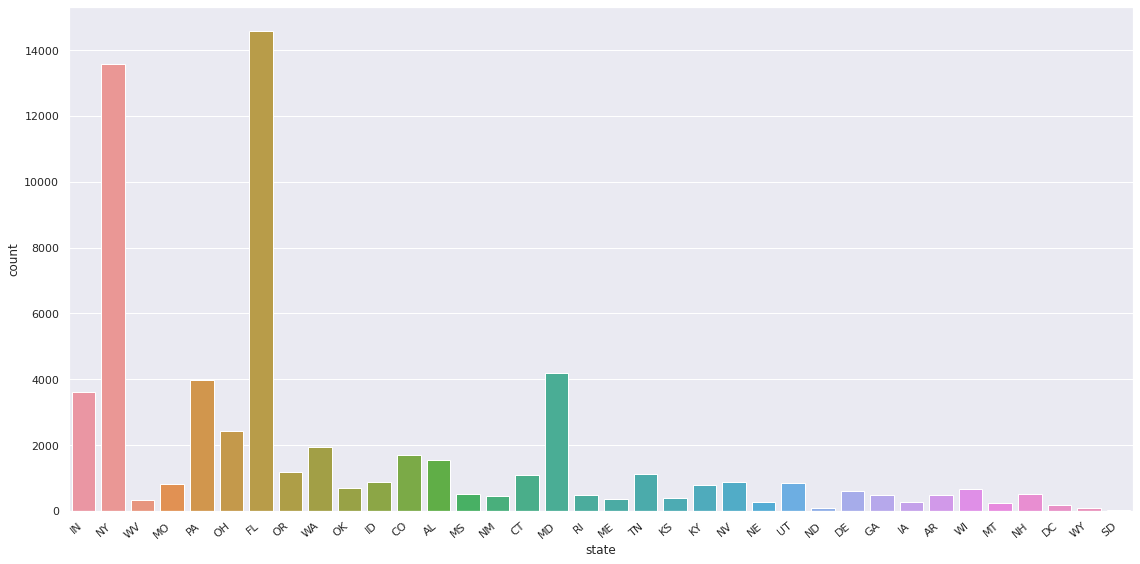

In [39]:
print(data[data['record_type']==1]['state'].value_counts())
f = plt.figure(figsize=(16,8))
ax = sb.countplot(x = "state", data = data[data['record_type']==1])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

According to this graph, purchases were the highest in Florida followed by New York. It was the least in South Dakota.
Trend of views and purchases is the same throughout all the states

10213    974
11517    864
10030    781
12091    730
10793    693
        ... 
16026      1
14941      1
12806      1
16031      1
16166      1
Name: location, Length: 5888, dtype: int64


<AxesSubplot:xlabel='location', ylabel='Count'>

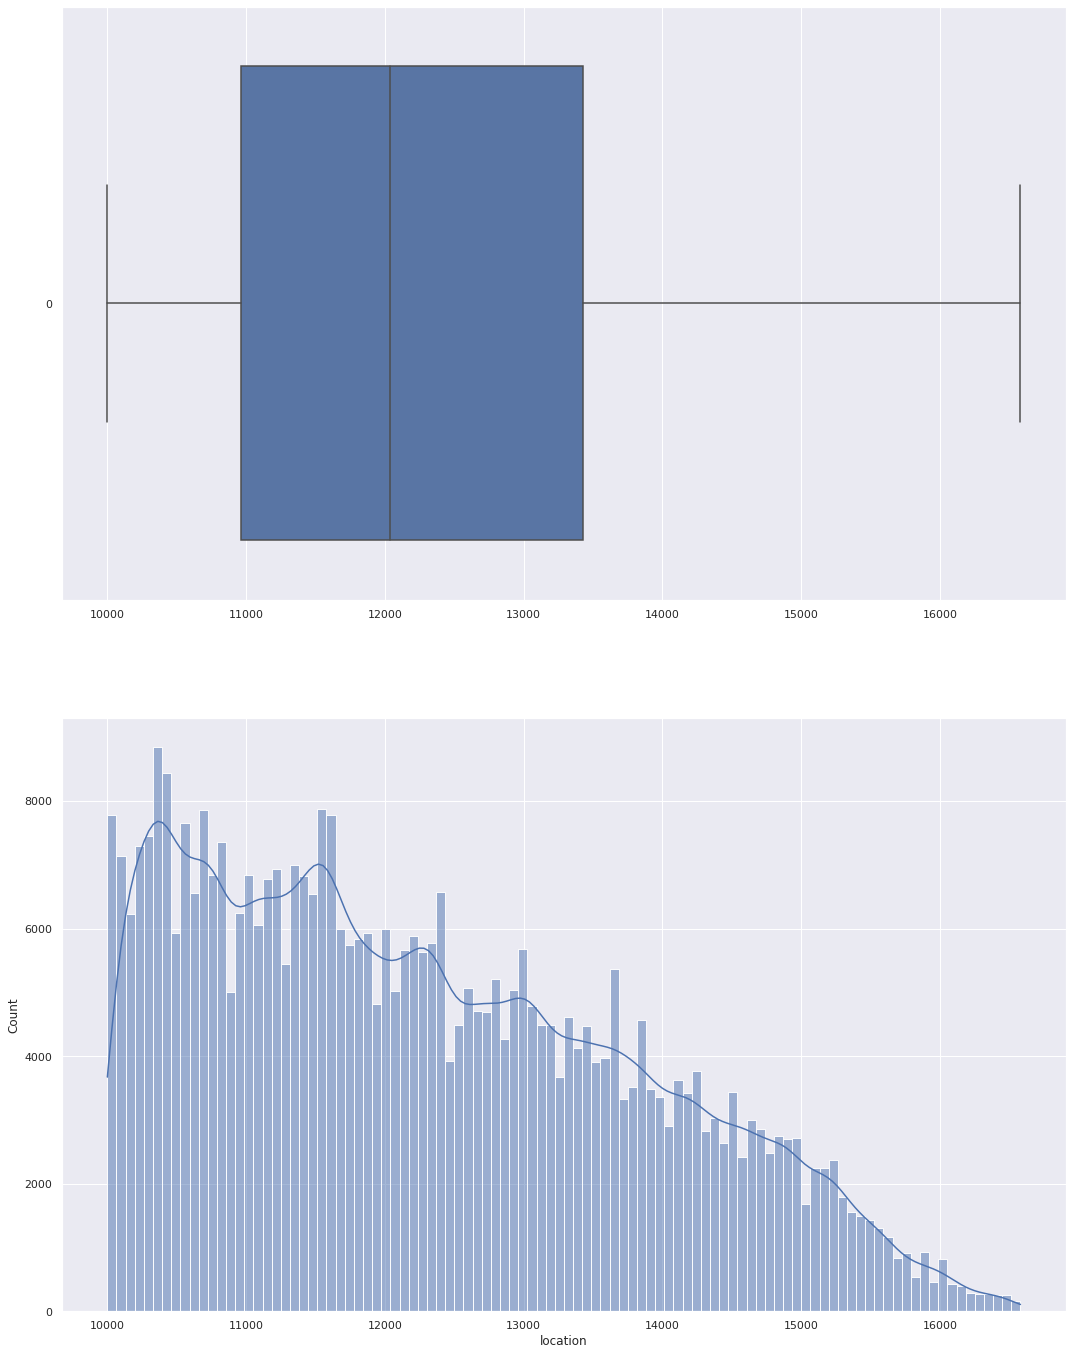

In [40]:
#location

print(data["location"].value_counts())
f, axes = plt.subplots(2, figsize=(18, 24))

sb.boxplot(data = data['location'], orient = "h", ax=axes[0])
sb.histplot(data = data["location"], kde = True, ax=axes[1])

3.0    114562
4.0    108632
1.0     98472
2.0     95781
Name: risk_factor, dtype: int64


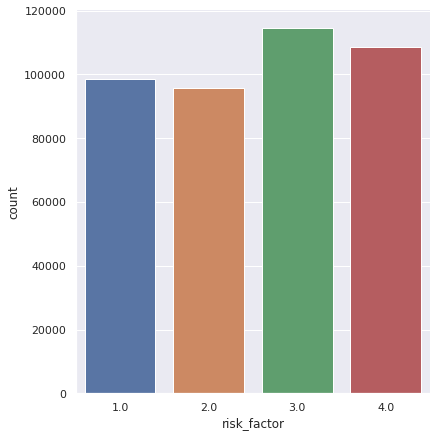

In [41]:
print(data["risk_factor"].value_counts())
sb.catplot(x = "risk_factor", data = data, kind = "count", height = 6)

In [42]:
data.location.value_counts()

10213    974
11517    864
10030    781
12091    730
10793    693
        ... 
16026      1
14941      1
12806      1
16031      1
16166      1
Name: location, Length: 5888, dtype: int64

This shows us that there are locations with multiple policies. Therefore the location must be a locality and not a single house.

3.0    114562
4.0    108632
1.0     98472
2.0     95781
Name: risk_factor, dtype: int64


<AxesSubplot:xlabel='location', ylabel='Count'>

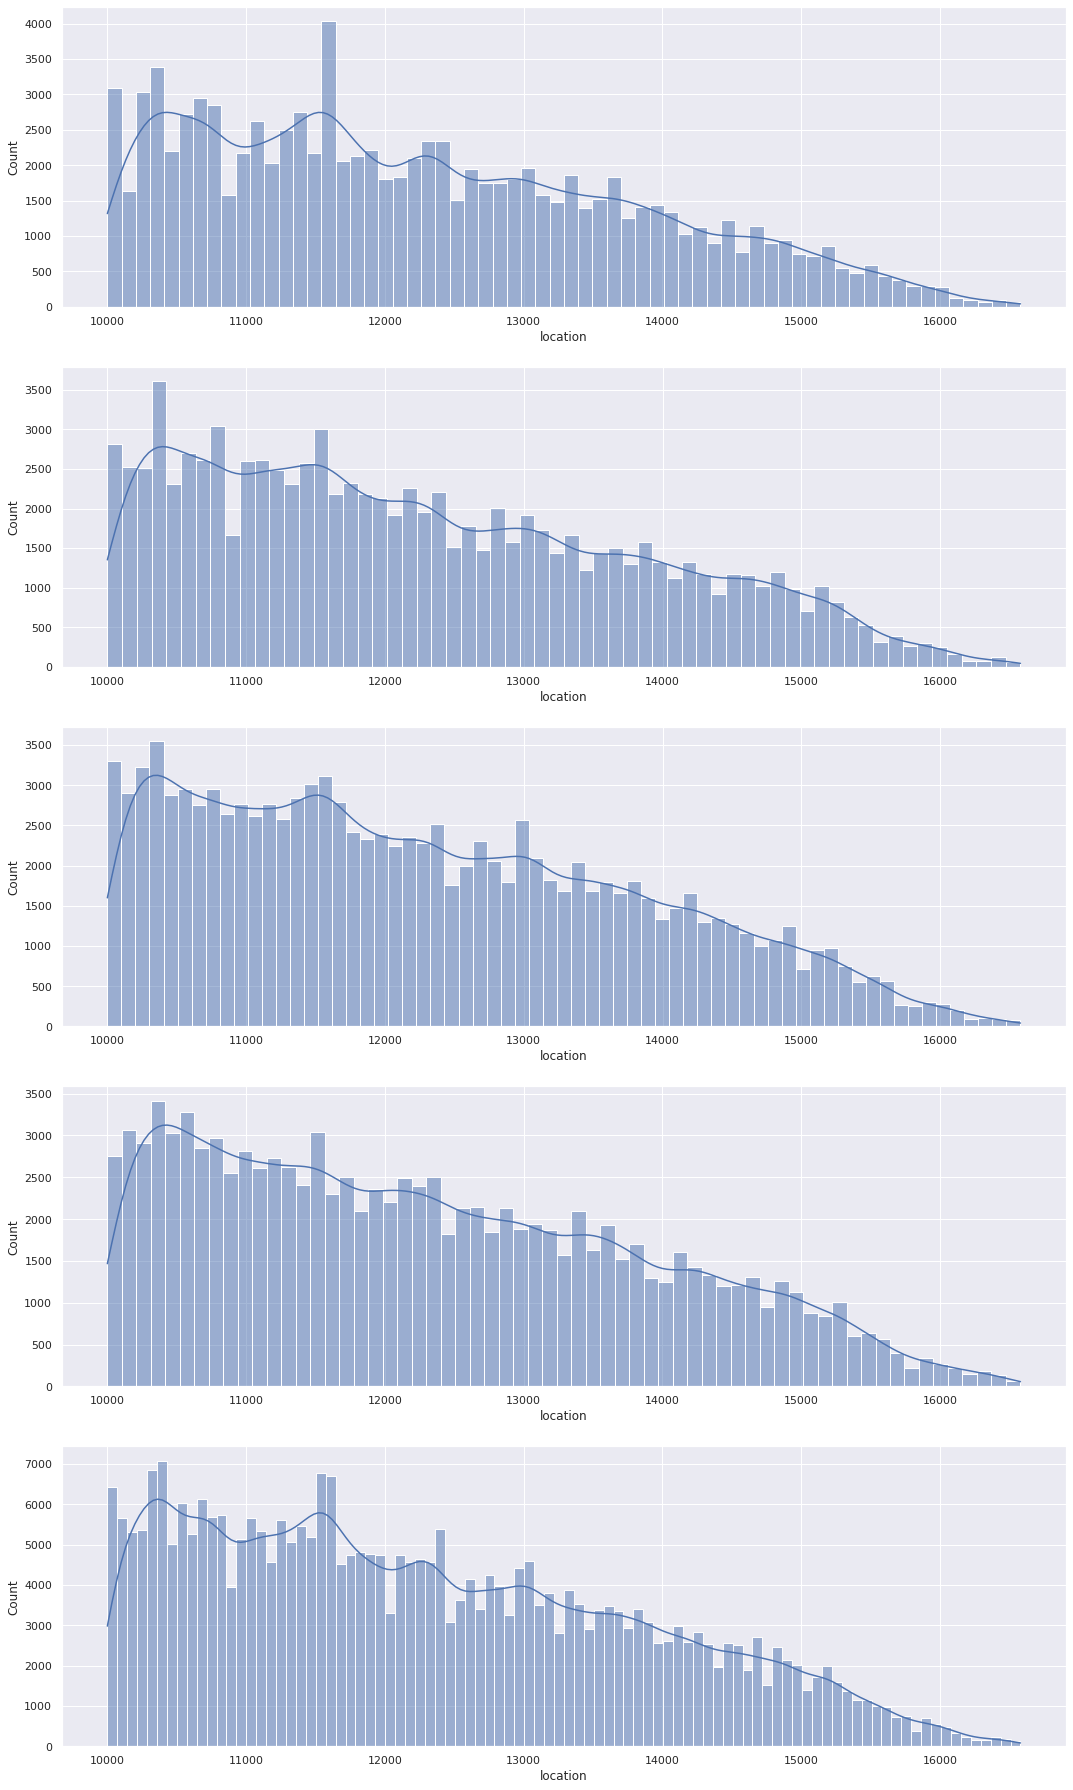

In [43]:
#finding correlation between location and risk_factor
#if there is a signigficant difference in the shape of the graph then there is correlation

print(data["risk_factor"].value_counts())
f, axes = plt.subplots(5, figsize=(18, 32))

count = 0
for risk in [1.0,2.0,3.0,4.0]:
    sb.histplot(x = "location", data = data[data['risk_factor'] == risk], kde = True, ax = axes[count])
    count += 1 

for risk in [1.0,2.0,3.0,4.0]:
    t = data[data['risk_factor']!=risk]    
sb.histplot(x = "location", data = t, kde = True, ax = axes[4]) #the graph of those with no risk factor

Although a few locations do stand out, overall there seems to be no correlation between location and risk factor. 

In [44]:
data.group_size.value_counts()

1    320197
2     90918
3      5893
4       439
Name: group_size, dtype: int64

1    320197
2     90918
3      5893
4       439
Name: group_size, dtype: int64


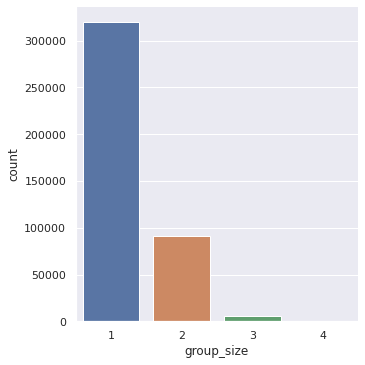

In [45]:
print(data["group_size"].value_counts())
sb.catplot(x = "group_size", data = data, kind = "count")

Most customers were individual customers rather than a group.

<AxesSubplot:xlabel='car_age', ylabel='Count'>

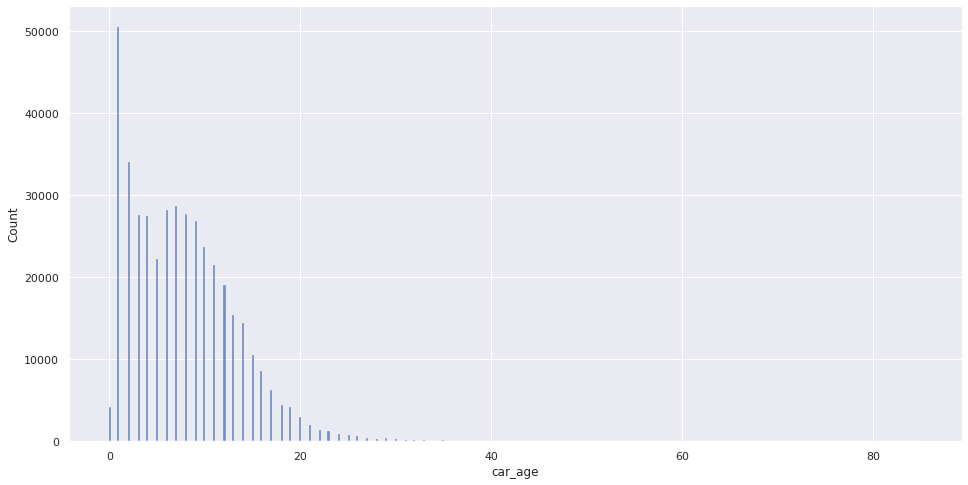

In [46]:
#car_age

f = plt.figure(figsize=(16, 8))
sb.histplot(data = data["car_age"])

Most of the cars were new at the time of purchase of insurance policies.

3.0    191392
1.0     88452
4.0     73014
2.0     64589
Name: C_previous, dtype: int64


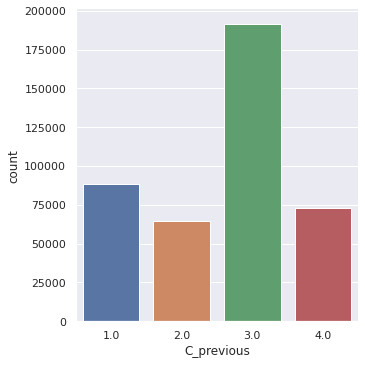

In [47]:
#C_previous, if people have applied for insurance before

print(data["C_previous"].value_counts())
sb.catplot(x = "C_previous", data = data, kind = "count")

For the coverage option C, option 3 seems to be the most popular and option 0 highly unpopular.

15.0    64736
2.0     44079
1.0     42179
3.0     41620
4.0     35712
5.0     32225
6.0     30164
7.0     26330
8.0     21591
9.0     19175
10.0    13765
0.0     12800
11.0     9480
12.0     8204
13.0     8149
14.0     7238
Name: duration_previous, dtype: int64


<AxesSubplot:xlabel='duration_previous', ylabel='Count'>

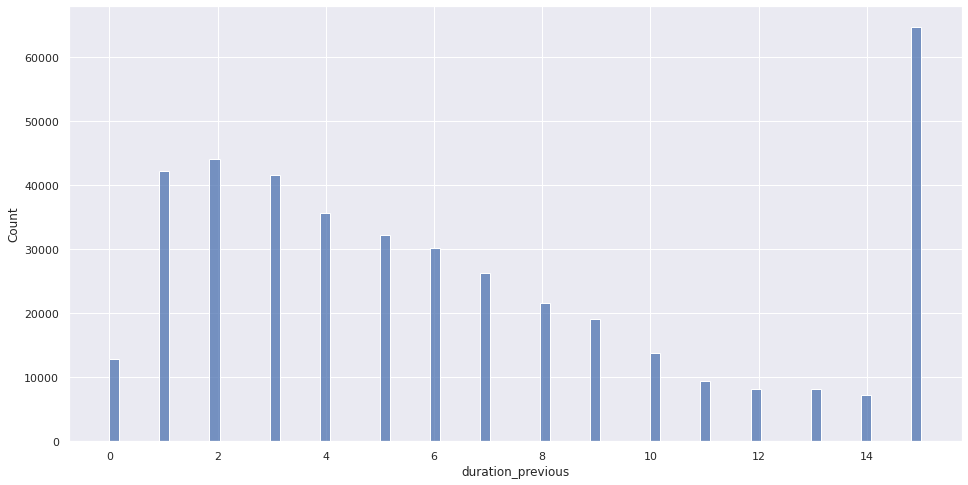

In [48]:
print(data["duration_previous"].value_counts())
f = plt.figure(figsize=(16, 8))
sb.histplot(data = data["duration_previous"])

The duration of the policies the customers had are decreasing at a steady rate up till 14 years. We can also observe a sudden rise and it peaks at 15 years.

<AxesSubplot:xlabel='age_oldest', ylabel='Count'>

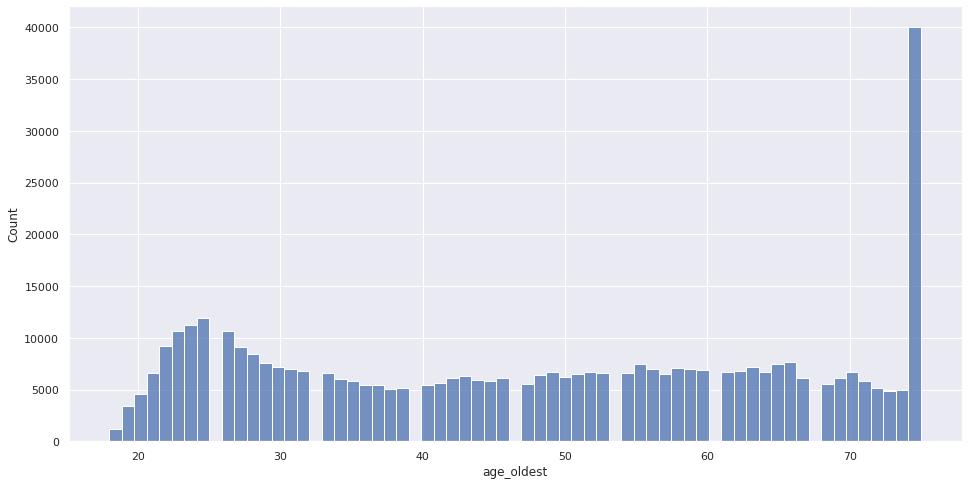

In [49]:
f = plt.figure(figsize=(16, 8))
sb.histplot(data = data["age_oldest"])

<AxesSubplot:xlabel='age_youngest', ylabel='Count'>

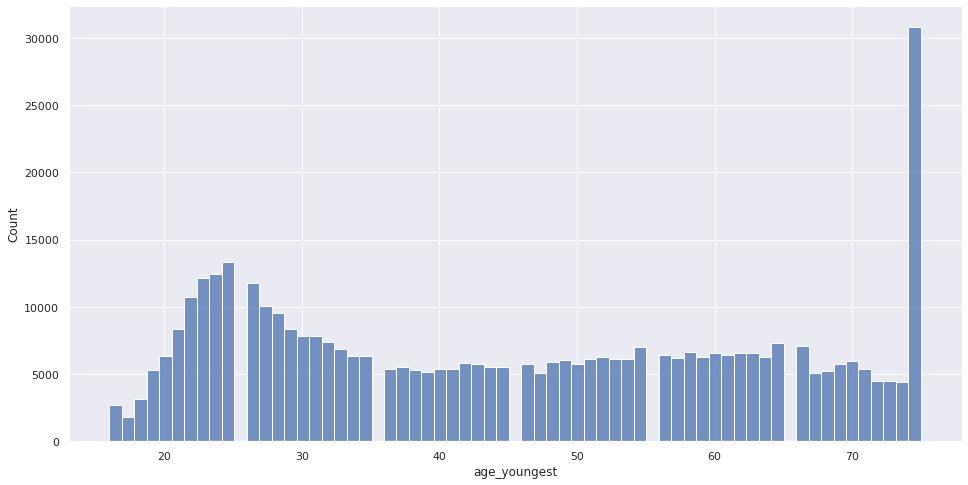

In [50]:
f = plt.figure(figsize=(16, 8))
sb.histplot(data = data["age_youngest"])

The young population seems to have a higher amount of people purchasing insurance policies. This population steadily decreases till it hits about 75. 
This could be due to there being an age entry of 75 years and older instead of age being categorized individually.

<AxesSubplot:xlabel='car_age', ylabel='G'>

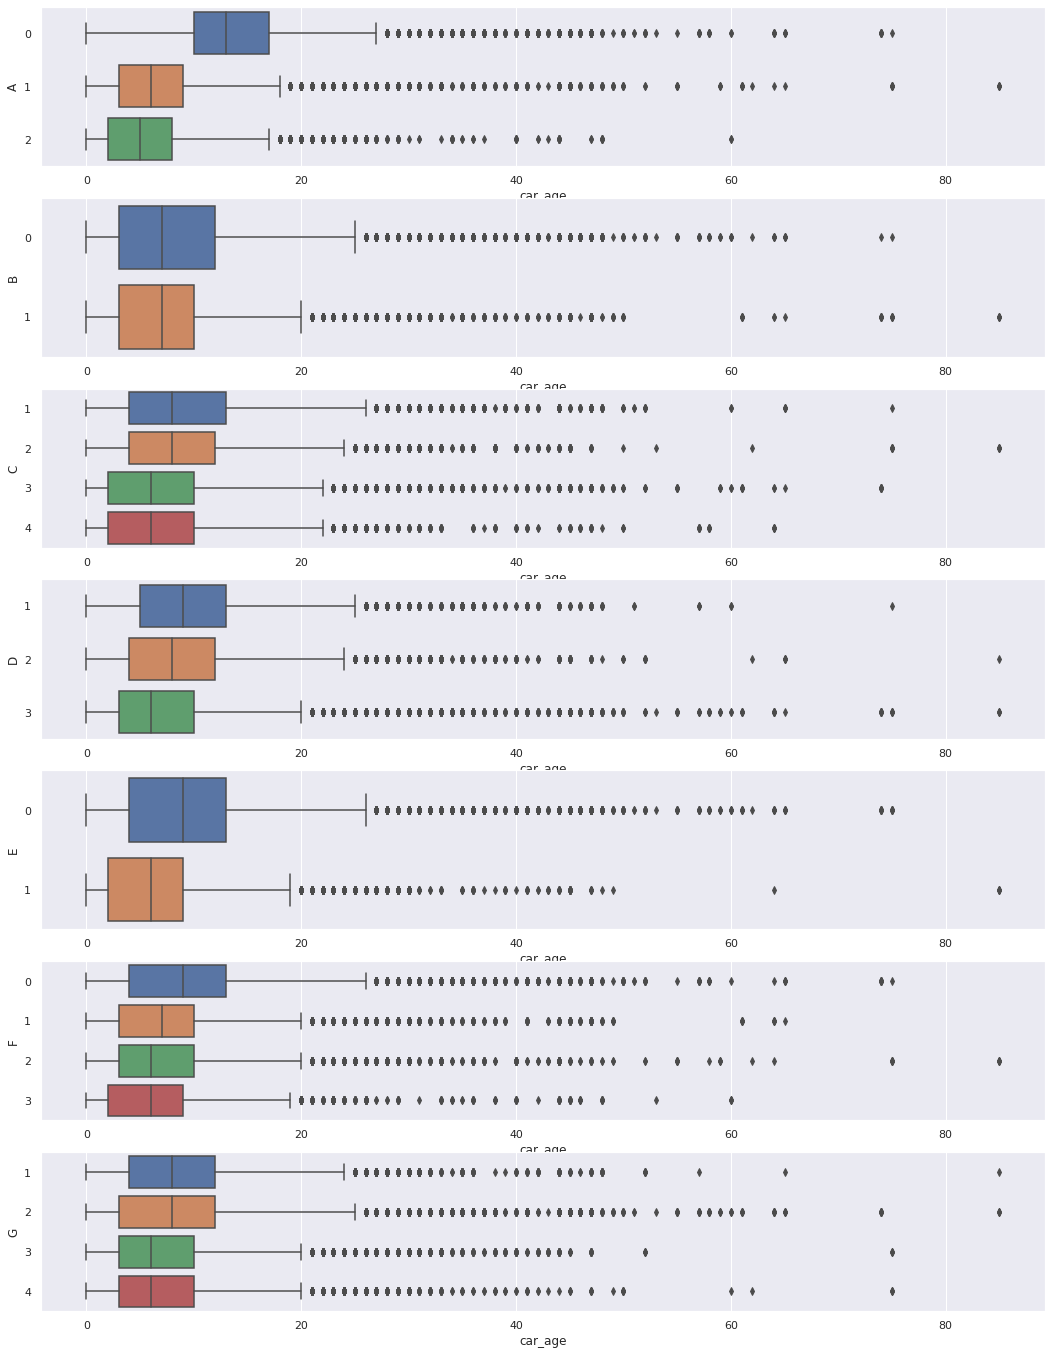

In [51]:
f, axes = plt.subplots(7, 1, figsize=(18, 24))

sb.boxplot(x = data['car_age'], y = data['A'], orient = 'h', ax = axes[0])
sb.boxplot(x = data['car_age'], y = data['B'], orient = 'h', ax = axes[1])
sb.boxplot(x = data['car_age'], y = data['C'], orient = 'h', ax = axes[2])
sb.boxplot(x = data['car_age'], y = data['D'], orient = 'h', ax = axes[3])
sb.boxplot(x = data['car_age'], y = data['E'], orient = 'h', ax = axes[4])
sb.boxplot(x = data['car_age'], y = data['F'], orient = 'h', ax = axes[5])
sb.boxplot(x = data['car_age'], y = data['G'], orient = 'h', ax = axes[6])

Customers do not differ much in choice of policy based on the age of their car, but we can say that there is a slight trend among slightly older car owners to opt for the first policy and newer car owners to opt the last policy among any given set of options as this is the general trend that can be seen across the coverage options.

In [52]:
train1 = data.sample(n=10000)
train2 = data.sample(n=20000)

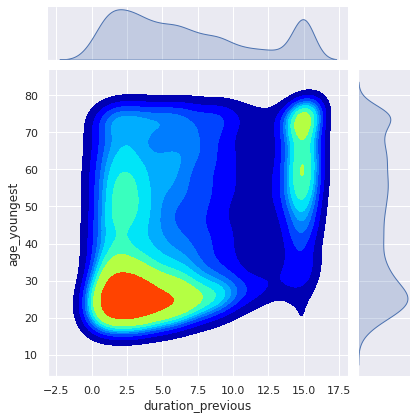

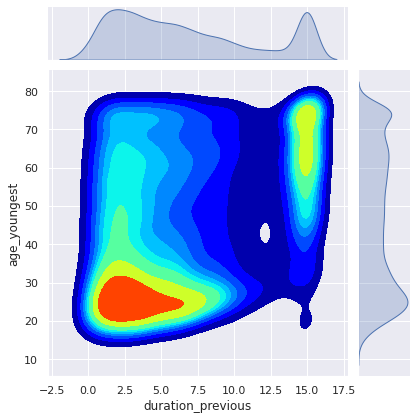

In [53]:
sb.jointplot(x=train1["duration_previous"], y=train1["age_youngest"], kind='kde',cmap=plt.cm.jet,fill=True) 
sb.jointplot(x=train2["duration_previous"], y=train2["age_youngest"], kind='kde',cmap=plt.cm.jet,fill=True) 
plt.show()

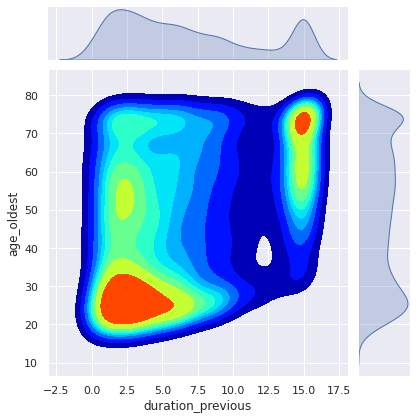

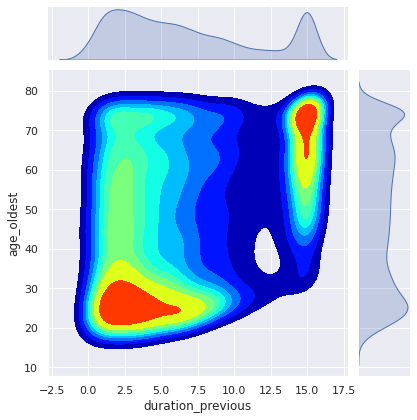

In [54]:
sb.jointplot(x=train1["duration_previous"], y=train1["age_oldest"], kind='kde',cmap=plt.cm.jet,fill=True) 
sb.jointplot(x=train2["duration_previous"], y=train2["age_oldest"], kind='kde',cmap=plt.cm.jet,fill=True) 
plt.show()

Groups with younger customers mostly had their previous policy for a shorter period of time. Some of the groups with older customers have also purchased policies previously for only a short period of time. The majority of the groups with older customers have had their previous policies for longer periods such as 15 years. 

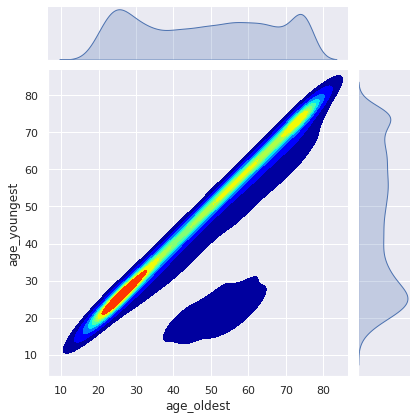

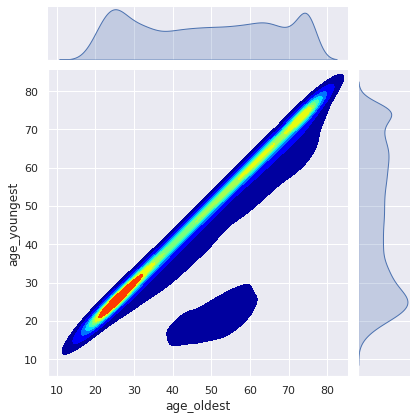

In [55]:
sb.jointplot(x=train1["age_oldest"], y=train1["age_youngest"], kind='kde',cmap=plt.cm.jet,fill=True) 
sb.jointplot(x=train2["age_oldest"], y=train2["age_youngest"], kind='kde',cmap=plt.cm.jet,fill=True) 
plt.show()

There is a higher number of groups with only younger customers than any other combination.

In [56]:
ndata = pd.read_csv("Insurance.csv")
ndata1 = ndata.sample(n=10000)
ndata2 = ndata.sample(n=20000)

<AxesSubplot:xlabel='age_youngest', ylabel='risk_factor'>

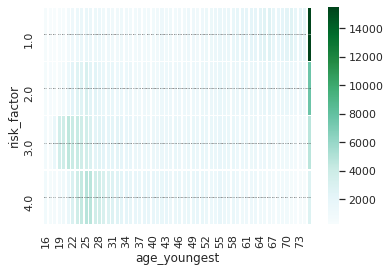

In [57]:
f = plt.figure(figsize = (6,4))
sb.heatmap(data.groupby(['risk_factor', 'age_youngest']).size().unstack(),
            linewidths = 0.4, annot = True, fmt = 'g', annot_kws = {"size": 2}, cmap = "BuGn")

<AxesSubplot:xlabel='age_oldest', ylabel='risk_factor'>

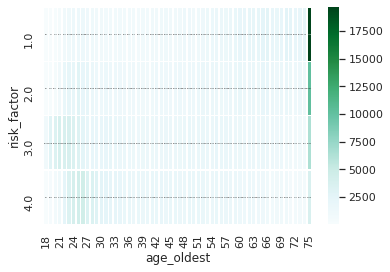

In [58]:
f = plt.figure(figsize = (6,4))
sb.heatmap(data.groupby(['risk_factor', 'age_oldest']).size().unstack(),
            linewidths = 0.4, annot = True, fmt = 'g', annot_kws = {"size": 2}, cmap = "BuGn")

From these graphs we can state that the group of people who have a risk factor of 4 seem to have a higher density of customers who are from the age group 22 to 28. For a risk factor of 3 we can see similar trends as it has a higher density of customers who are from the age group 19 to 25. Customers who are above the age of 73 seem to be dense in the groups of risk factor 1 and 2.

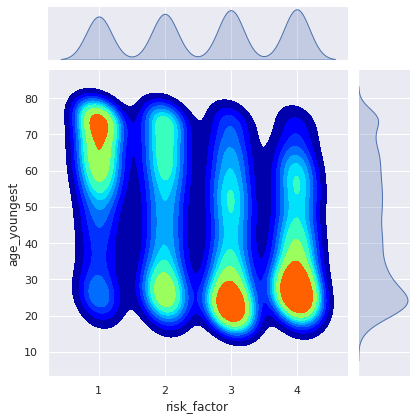

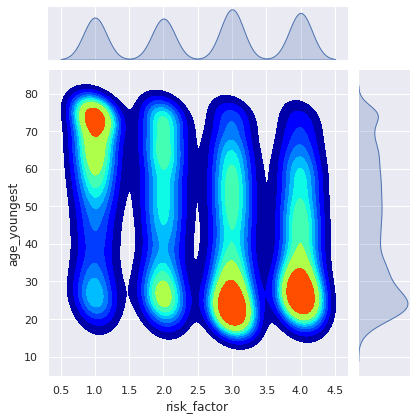

In [59]:
sb.jointplot(x=ndata1["risk_factor"], y=ndata1["age_youngest"], kind='kde',cmap=plt.cm.jet,fill=True) 
sb.jointplot(x=ndata2["risk_factor"], y=ndata2["age_youngest"], kind='kde',cmap=plt.cm.jet,fill=True) 
plt.show()

Risk factor 1 is mostly seen where the age of the youngest person in the group is around 70. Risk factors of 3 and 4 are mostly seen where the age of the youngest member in the group is between the ages of 20 and 30.

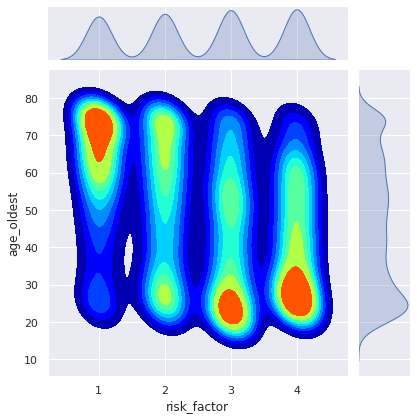

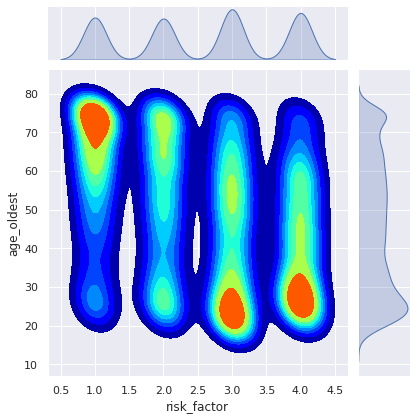

In [60]:
sb.jointplot(x=ndata1["risk_factor"], y=ndata1["age_oldest"], kind='kde',cmap=plt.cm.jet,fill=True) 
sb.jointplot(x=ndata2["risk_factor"], y=ndata2["age_oldest"], kind='kde',cmap=plt.cm.jet,fill=True) 
plt.show()

Risk factor 1 is mostly seen where the age of the oldest person in the group is around 70. Risk factors of 3 and 4 are mostly seen where the age of the oldest member in the group is between the ages of 20 and 30.

<AxesSubplot:xlabel='car_age', ylabel='risk_factor'>

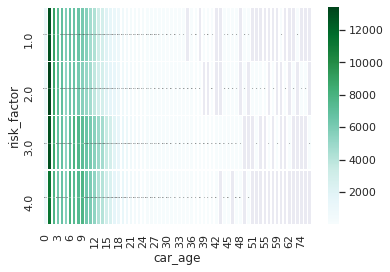

In [61]:
f = plt.figure(figsize = (6,4))
sb.heatmap(data.groupby(['risk_factor', 'car_age']).size().unstack(),
            linewidths = 0.4, annot = True, fmt = 'g', annot_kws = {"size": 2}, cmap = "BuGn")

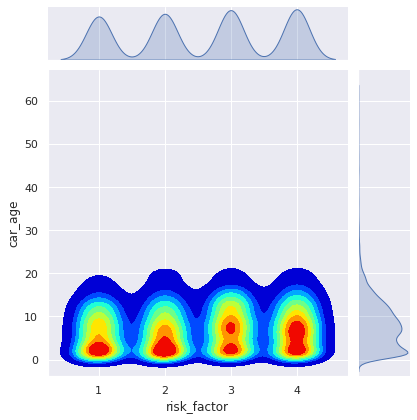

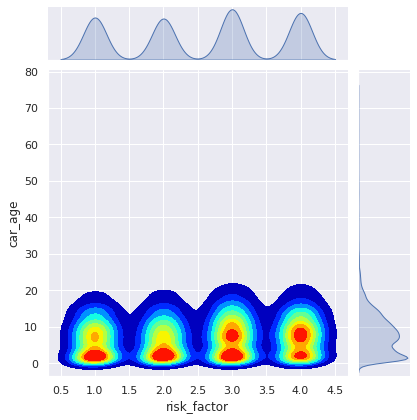

In [62]:
sb.jointplot(x=ndata1["risk_factor"], y=ndata1["car_age"], kind='kde',cmap=plt.cm.jet,fill=True) 
sb.jointplot(x=ndata2["risk_factor"], y=ndata2["car_age"], kind='kde',cmap=plt.cm.jet,fill=True) 
plt.show()

Among cars bought in the last 20 years, newer cars have lower risk factors than older ones.

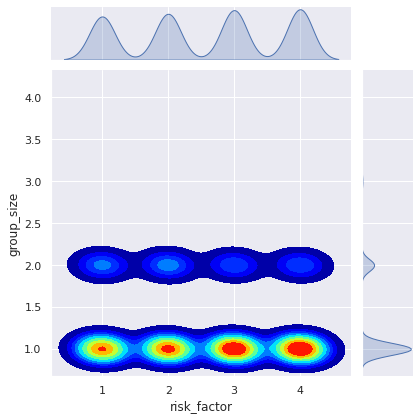

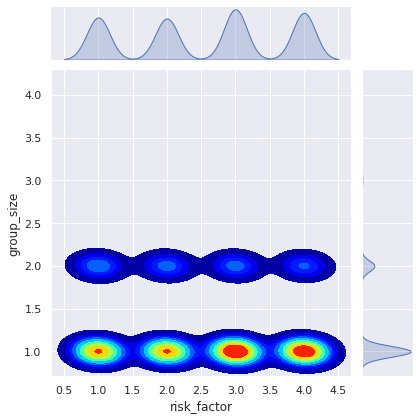

In [63]:
sb.jointplot(x=ndata1["risk_factor"], y=ndata1["group_size"], kind='kde',cmap=plt.cm.jet,fill=True) 
sb.jointplot(x=ndata2["risk_factor"], y=ndata2["group_size"], kind='kde',cmap=plt.cm.jet,fill=True) 
plt.show()

Groups with only one person tend to have a higher risk factor. No other conclusions can be made from this plot.

In [64]:
clean_data = pd.DataFrame(data[["risk_factor", "age_youngest", "age_oldest", "car_age", "group_size"]])

              risk_factor  age_youngest  age_oldest   car_age  group_size
risk_factor      1.000000     -0.295933   -0.303132  0.081630   -0.057335
age_youngest    -0.295933      1.000000    0.914146  0.020191   -0.014303
age_oldest      -0.303132      0.914146    1.000000  0.023182    0.223061
car_age          0.081630      0.020191    0.023182  1.000000   -0.032148
group_size      -0.057335     -0.014303    0.223061 -0.032148    1.000000


<AxesSubplot:>

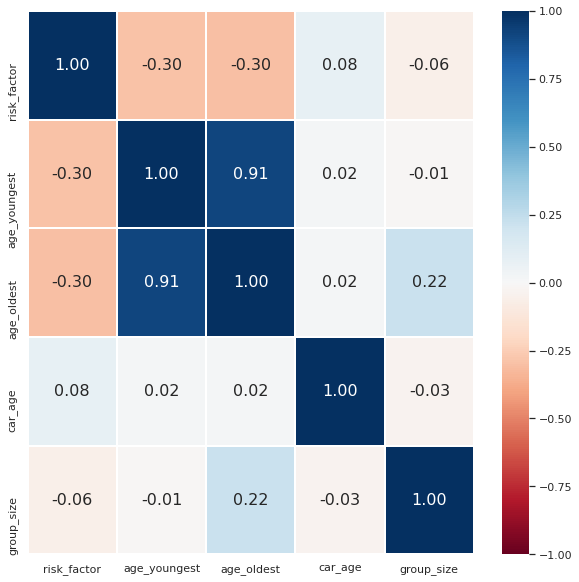

In [65]:
print(clean_data.corr())
f = plt.figure(figsize=(10, 10))
sb.heatmap(clean_data.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 16}, cmap = "RdBu")

It is very clear from the graphs plotted above that there is no correlation between the age of the car and size of the group with risk factor.
However, there appears to be a weak correlation between age_youngest and age_oldest with the risk_factor, which implies that as the age of the customer increases, the value of the risk factor decreases.

<AxesSubplot:xlabel='homeowner', ylabel='cost'>

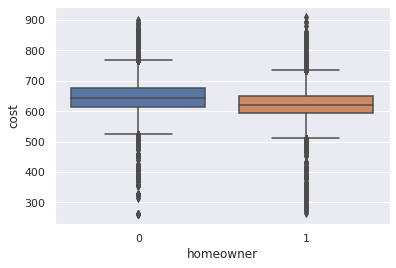

In [66]:
sb.boxplot(x = "homeowner", y = "cost", data = data,)

From these boxplots, we can say that customers who do not own a home purchase slightly higher costing insurance policies

<AxesSubplot:xlabel='married_couple', ylabel='cost'>

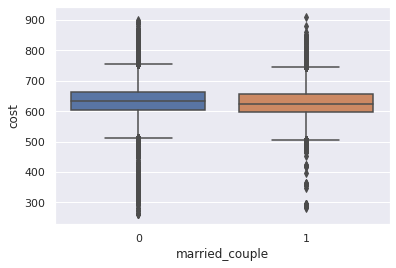

In [67]:
sb.boxplot(x = "married_couple", y = "cost", data = data)

From these boxplots, we can say that customers who are unmarried purchase extremely slightly higher costing insurance policies

#### What time is the most advantageous for the insurance company through the day?

In [68]:
timedata = pd.timedelta_range(0,periods=24,freq='H')

In [69]:
tdata = pd.read_csv("Insurance.csv")

In [70]:
tdata = tdata[["customer_ID","time","day","record_type"]]

In [71]:
tdata.head()

,customer_ID,time,day,record_type
0,10000000,08:35,0,0
1,10000000,08:38,0,0
2,10000000,08:38,0,0
3,10000000,08:39,0,0
4,10000000,11:55,0,0


In [72]:
tdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665249 entries, 0 to 665248
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_ID  665249 non-null  int64 
 1   time         665249 non-null  object
 2   day          665249 non-null  int64 
 3   record_type  665249 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 20.3+ MB


In [73]:
tdata["time"] = pd.to_datetime(tdata["time"])

In [74]:
tdata["time"] = tdata["time"] - np.datetime64(str(tdata.loc[0,"time"])[:10])

In [75]:
tdata.head()

,customer_ID,time,day,record_type
0,10000000,0 days 08:35:00,0,0
1,10000000,0 days 08:38:00,0,0
2,10000000,0 days 08:38:00,0,0
3,10000000,0 days 08:39:00,0,0
4,10000000,0 days 11:55:00,0,0


In [76]:
tdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665249 entries, 0 to 665248
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype          
---  ------       --------------   -----          
 0   customer_ID  665249 non-null  int64          
 1   time         665249 non-null  timedelta64[ns]
 2   day          665249 non-null  int64          
 3   record_type  665249 non-null  int64          
dtypes: int64(3), timedelta64[ns](1)
memory usage: 20.3 MB


In [77]:
tdata["bin"]=0

In [78]:
for i in tdata.index:
    tdata.at[i,"bin"] = int(str(tdata.at[i,"time"])[7:9])

In [79]:
tdata.sample(n=20)

,customer_ID,time,day,record_type,bin
581377,10133607,0 days 16:28:00,3,0,16
94969,10022021,0 days 08:48:00,2,0,8
8712,10002006,0 days 11:11:00,2,0,11
467816,10107552,0 days 17:18:00,1,0,17
132302,10030706,0 days 16:55:00,4,0,16
154394,10035830,0 days 09:34:00,0,0,9
223062,10051597,0 days 13:08:00,0,0,13
77705,10018025,0 days 15:32:00,0,1,15
103446,10023968,0 days 09:31:00,4,0,9
664902,10152653,0 days 16:10:00,4,1,16


In [80]:
time = pd.Series(tdata.bin.value_counts().sort_index(ascending = True).values, index = timedata) 
time

0 days 00:00:00       40
0 days 01:00:00       43
0 days 02:00:00        9
0 days 03:00:00       21
0 days 04:00:00       28
0 days 05:00:00       61
0 days 06:00:00      205
0 days 07:00:00     3564
0 days 08:00:00    30874
0 days 09:00:00    59511
0 days 10:00:00    73311
0 days 11:00:00    74702
0 days 12:00:00    75510
0 days 13:00:00    80859
0 days 14:00:00    81926
0 days 15:00:00    80862
0 days 16:00:00    54499
0 days 17:00:00    26649
0 days 18:00:00    14120
0 days 19:00:00     5430
0 days 20:00:00     1680
0 days 21:00:00      737
0 days 22:00:00      389
0 days 23:00:00      219
Freq: H, dtype: int64

In [81]:
timedata = pd.timedelta_range(0,periods=4,freq='12H')

<AxesSubplot:xlabel='Time of the day', ylabel='Number of Views'>

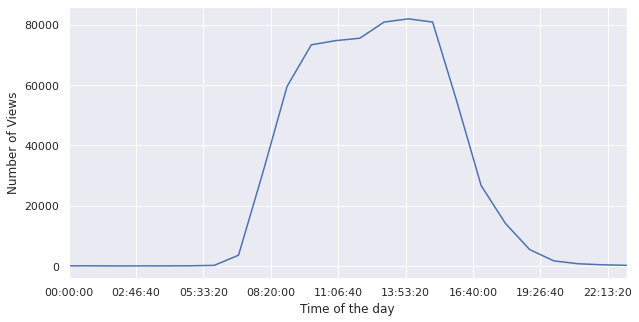

In [82]:
f, axes = plt.subplots(figsize=(10,5))
time.plot(xlabel='Time of the day',ylabel='Number of Views')

In [83]:
timedata = pd.timedelta_range(0,periods=24,freq='H')
num = tdata[tdata.record_type==1].bin.value_counts()
num = num.append(pd.Series({3:0}))
time = pd.Series(num.sort_index(ascending = True).values, index = timedata)

<AxesSubplot:xlabel='Time of the day', ylabel='Number of Purchases'>

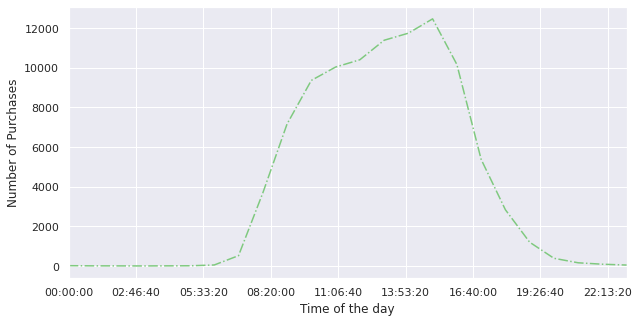

In [84]:

f, axes = plt.subplots(figsize=(10,5))
time.plot(xlabel='Time of the day',ylabel='Number of Purchases',colormap='Accent',linestyle='dashdot')

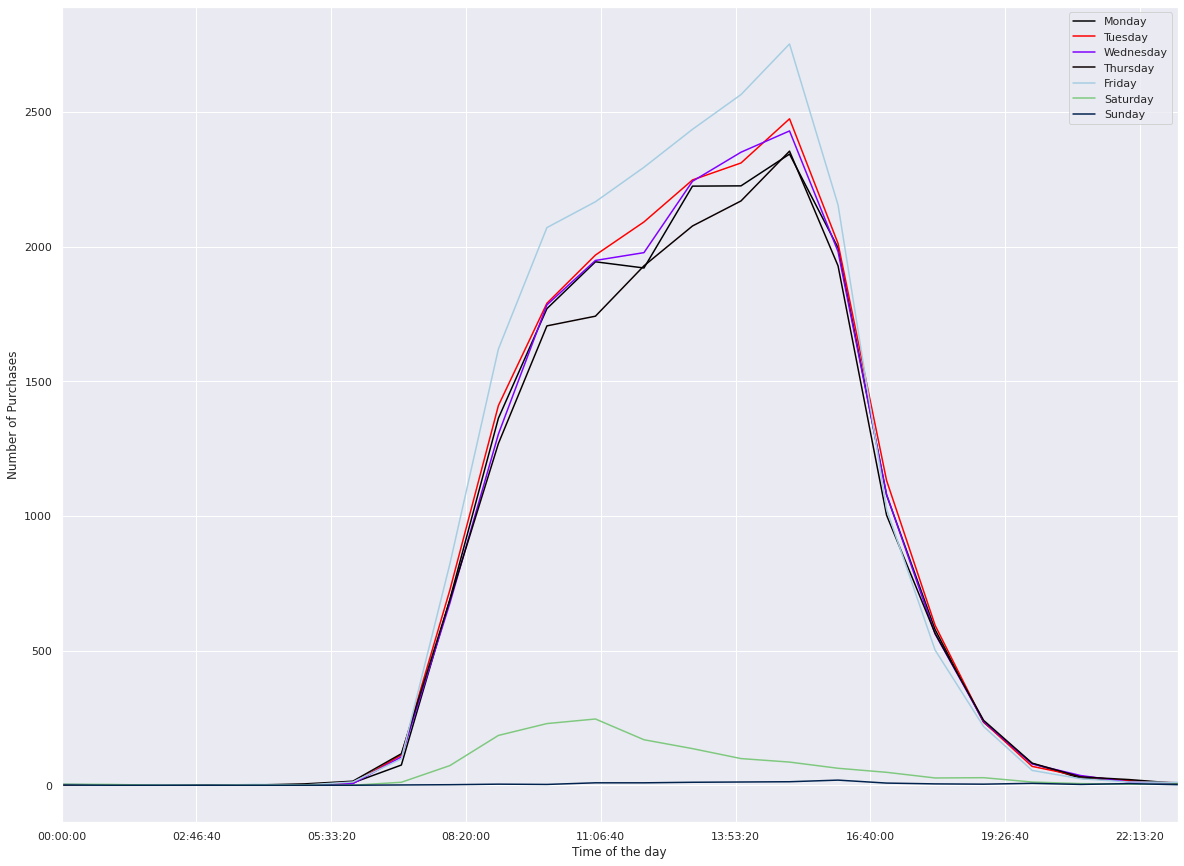

In [85]:
color = ['magma', 'flag', 'rainbow', 'hot', 'Paired', 'Accent','cividis']
timedata = pd.timedelta_range(0,periods=24,freq='H')
f, axes = plt.subplots(figsize=(20,15))

for i in range(7):
    num = tdata[tdata.record_type==1]
    num = num[num.day==i].bin.value_counts()
    for j in range(24):
        if( not (j in num.index) ):
            num = num.append(pd.Series({j:0}))
    time = pd.Series(num.sort_index(ascending = True).values, index = timedata)
    time.plot(xlabel='Time of the day',ylabel='Number of Purchases',colormap=color[i])
    
plt.legend([ "Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday","Sunday"])

Sales start at around 7 AM and increases very steeply till around 10 AM after which there is a slower increase till around 4 PM which is when the purchases of policies peak. After this peak there is an extremely sharp decline in the sales till it almost comes to a standstill at 8PM.

# Linear Regression

Let's start Linear Regression by importing the required libraries

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [87]:
response = pd.DataFrame(data["cost"])

In [88]:
predictors = data[["shopping_pt","group_size","homeowner","car_age","risk_factor",       
                   "age_oldest","age_youngest","married_couple","C_previous","duration_previous"]]

In [89]:
predictors.head()

,shopping_pt,group_size,homeowner,car_age,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous
0,1,2,0,2,3.0,46,42,1,1.0,2.0
1,2,2,0,2,3.0,46,42,1,1.0,2.0
2,3,2,0,2,3.0,46,42,1,1.0,2.0
3,4,2,0,2,3.0,46,42,1,1.0,2.0
4,5,2,0,2,3.0,46,42,1,1.0,2.0


In [90]:
predictors = pd.concat([data[['A','B','C','D','E','F','G']],predictors], axis=1)

In [91]:
predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417447 entries, 0 to 417446
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   A                  417447 non-null  int64  
 1   B                  417447 non-null  int64  
 2   C                  417447 non-null  int64  
 3   D                  417447 non-null  int64  
 4   E                  417447 non-null  int64  
 5   F                  417447 non-null  int64  
 6   G                  417447 non-null  int64  
 7   shopping_pt        417447 non-null  int64  
 8   group_size         417447 non-null  int64  
 9   homeowner          417447 non-null  int64  
 10  car_age            417447 non-null  int64  
 11  risk_factor        417447 non-null  float64
 12  age_oldest         417447 non-null  int64  
 13  age_youngest       417447 non-null  int64  
 14  married_couple     417447 non-null  int64  
 15  C_previous         417447 non-null  float64
 16  du

In [92]:
data.car_value

0         g
1         g
2         g
3         g
4         g
         ..
417442    g
417443    g
417444    f
417445    f
417446    g
Name: car_value, Length: 417447, dtype: object

car_value is categorical variable based on the value of the car, with 'a' as the highest car value and 'g' as the lowest car value. To utilise the same, we convert the variable to an integeral categorical variable from a object categorical variable using a LabelEncoder

In [93]:
data.car_value.value_counts()

e    135026
f    113445
d     69283
g     63481
h     20106
c     11911
i      2867
b       712
a       616
Name: car_value, dtype: int64

In [94]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [95]:
le.fit(data.car_value)

LabelEncoder()

In [96]:
le.classes_

array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'], dtype=object)

In [97]:
car_val = pd.DataFrame(le.transform(data["car_value"]))
car_val.rename(columns={0:"car_value"},inplace=True)

In [98]:
car_val.head()

,car_value
0,6
1,6
2,6
3,6
4,6


In [99]:
predictors = pd.concat([car_val,predictors], axis=1)

In [100]:
predictors.car_value.value_counts()

4    135026
5    113445
3     69283
6     63481
7     20106
2     11911
8      2867
1       712
0       616
Name: car_value, dtype: int64

The state and day are categorical object-type variables whose values have no inherent odering to them. Hence, we use OneHot Encoder to encode them into columns with binary values.

In [101]:
from sklearn.preprocessing import OneHotEncoder

In [102]:
hot = OneHotEncoder()

In [103]:
hot.fit(data[["state"]])

OneHotEncoder()

In [104]:
newstate = pd.DataFrame(hot.transform(data[["state"]]).toarray(), columns=hot.get_feature_names())

In [105]:
newstate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417447 entries, 0 to 417446
Data columns (total 36 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0_AL   417447 non-null  float64
 1   x0_AR   417447 non-null  float64
 2   x0_CO   417447 non-null  float64
 3   x0_CT   417447 non-null  float64
 4   x0_DC   417447 non-null  float64
 5   x0_DE   417447 non-null  float64
 6   x0_FL   417447 non-null  float64
 7   x0_GA   417447 non-null  float64
 8   x0_IA   417447 non-null  float64
 9   x0_ID   417447 non-null  float64
 10  x0_IN   417447 non-null  float64
 11  x0_KS   417447 non-null  float64
 12  x0_KY   417447 non-null  float64
 13  x0_MD   417447 non-null  float64
 14  x0_ME   417447 non-null  float64
 15  x0_MO   417447 non-null  float64
 16  x0_MS   417447 non-null  float64
 17  x0_MT   417447 non-null  float64
 18  x0_ND   417447 non-null  float64
 19  x0_NE   417447 non-null  float64
 20  x0_NH   417447 non-null  float64
 21  x0_NM   41

In [106]:
hot.fit((data[["location"]]-10000)//80)

OneHotEncoder()

In [107]:
newloc = pd.DataFrame(hot.transform((data[["location"]]-10000)//80).toarray(), columns=hot.get_feature_names())

In [108]:
hot.fit(data[["day"]])

OneHotEncoder()

In [109]:
newday = pd.DataFrame(hot.transform(data[["day"]]).toarray(), columns=hot.get_feature_names())

In [110]:
predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417447 entries, 0 to 417446
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   car_value          417447 non-null  int64  
 1   A                  417447 non-null  int64  
 2   B                  417447 non-null  int64  
 3   C                  417447 non-null  int64  
 4   D                  417447 non-null  int64  
 5   E                  417447 non-null  int64  
 6   F                  417447 non-null  int64  
 7   G                  417447 non-null  int64  
 8   shopping_pt        417447 non-null  int64  
 9   group_size         417447 non-null  int64  
 10  homeowner          417447 non-null  int64  
 11  car_age            417447 non-null  int64  
 12  risk_factor        417447 non-null  float64
 13  age_oldest         417447 non-null  int64  
 14  age_youngest       417447 non-null  int64  
 15  married_couple     417447 non-null  int64  
 16  C_

In [111]:
synergy = ["shopping_pt","group_size","car_age","risk_factor","age_oldest","age_youngest","C_previous","duration_previous"]
count = 0
for i in synergy:
    for j in synergy[count:]:
        predictors[i+"-"+j]= predictors[i]*predictors[j]
    count = count + 1

In [112]:
for i in synergy:
        predictors["sqrt"+"-"+i]= predictors[i]**1/2

In [113]:
predictors = pd.concat([predictors,newstate],axis=1)

In [114]:
predictors = pd.concat([predictors,newday],axis=1)

In [115]:
predictors.head()

,car_value,A,B,C,D,E,F,G,shopping_pt,group_size,...,x0_WI,x0_WV,x0_WY,x0_0,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6
0,6,1,0,2,2,1,2,2,1,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,1,0,2,2,1,2,1,2,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,1,0,2,2,1,2,1,3,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,1,0,2,2,1,2,1,4,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,1,0,2,2,1,2,1,5,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417447 entries, 0 to 417446
Columns: 105 entries, car_value to x0_6
dtypes: float64(75), int64(30)
memory usage: 334.4 MB


Fitting the predictors and the response(score) into a linear regression model after splitting the entire dataset into train and test data

Intercept of Regression 	: b =  [651.26424153]
Coefficients of Regression 	: a =  [[ 3.44274154e+00  1.24505793e+01  2.56766292e+00  3.16136763e+00
  -5.74035817e-01  1.30052940e+01  3.86041539e+00  1.36664375e+00
   4.77004630e-01  7.39473883e+00 -1.28736049e+01 -7.37285589e-01
   1.86972704e+01 -9.75481693e-01 -1.86521408e+00 -5.34581955e+00
  -1.10680192e+01 -3.65405165e+00 -9.70702189e-02  6.48427405e-02
  -1.91052611e-02  2.13098419e-02  7.37875498e-03 -9.38441307e-03
   1.87068478e-01  4.14868074e-02 -1.30071876e+00 -8.54615151e-02
  -1.35380581e+00  4.05635951e-01 -5.17096488e-01 -1.36888682e-01
   1.18695514e-01  3.19816078e-02 -2.15456410e-01  3.41619999e-03
  -1.22299946e-03  1.54650670e-02 -9.22502550e-03 -2.30978112e+00
   3.96947298e-02  1.11389301e-03  3.12423106e-01  3.45534366e-02
   1.21845968e-03  2.14913826e-02 -2.16042014e-02  6.86067354e-05
   1.08328315e-02  5.45354887e-02  9.10514842e-03  7.99919871e-01
   1.84585089e-01  1.53335108e-01  2.38502315e-01  3.6973694

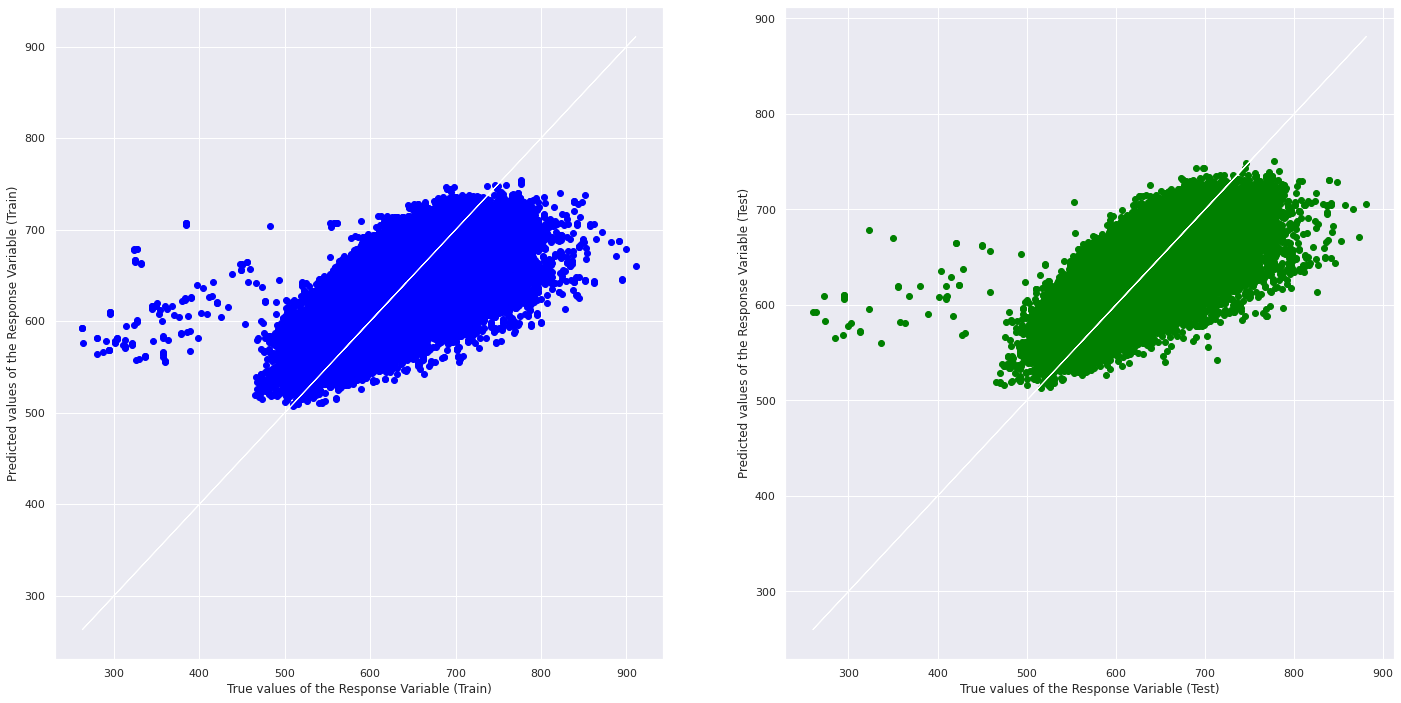

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5061773002177307
Mean Squared Error (MSE) 	: 1055.659509040302

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.5048224835327231
Mean Squared Error (MSE) 	: 1055.5440897202388



In [117]:
y = pd.DataFrame(data["cost"])
X = pd.DataFrame(predictors)

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

In [118]:
linreg.coef_

array([[ 3.44274154e+00,  1.24505793e+01,  2.56766292e+00,
         3.16136763e+00, -5.74035817e-01,  1.30052940e+01,
         3.86041539e+00,  1.36664375e+00,  4.77004630e-01,
         7.39473883e+00, -1.28736049e+01, -7.37285589e-01,
         1.86972704e+01, -9.75481693e-01, -1.86521408e+00,
        -5.34581955e+00, -1.10680192e+01, -3.65405165e+00,
        -9.70702189e-02,  6.48427405e-02, -1.91052611e-02,
         2.13098419e-02,  7.37875498e-03, -9.38441307e-03,
         1.87068478e-01,  4.14868074e-02, -1.30071876e+00,
        -8.54615151e-02, -1.35380581e+00,  4.05635951e-01,
        -5.17096488e-01, -1.36888682e-01,  1.18695514e-01,
         3.19816078e-02, -2.15456410e-01,  3.41619999e-03,
        -1.22299946e-03,  1.54650670e-02, -9.22502550e-03,
        -2.30978112e+00,  3.96947298e-02,  1.11389301e-03,
         3.12423106e-01,  3.45534366e-02,  1.21845968e-03,
         2.14913826e-02, -2.16042014e-02,  6.86067354e-05,
         1.08328315e-02,  5.45354887e-02,  9.10514842e-0

#### Code to evaluate and remove unecessary columns which do not contribute to the explained variance

In [119]:
def remove(data):
    
    data = data.sample(n=10000)
    score = 0
    col_name = "DCHOPS"
    
    for j in data:
    
        if j=="cost":
            continue;
        
        array = []
        for i in data:
            if i!=j and i!="cost":
                array.append(i)

        y = pd.DataFrame(data["cost"])
        X = pd.DataFrame(data[array])

        linreg = LinearRegression()        
        linreg.fit(X, y)       
    
        if linreg.score(X, y) > score:
            col_name = j
            score = linreg.score(X, y)

    data = data.drop([col_name],axis=1)
    
    return data,score

In [120]:
newdata = pd.concat([predictors,data["cost"]],axis=1)
score = []

for k in range(len(newdata.columns)-2):
    tup = remove(newdata)
    newdata = tup[0]
    score.append(tup[1])
    print("COUNT: ",k)

COUNT:  0
COUNT:  1
COUNT:  2
COUNT:  3
COUNT:  4
COUNT:  5
COUNT:  6
COUNT:  7
COUNT:  8
COUNT:  9
COUNT:  10
COUNT:  11
COUNT:  12
COUNT:  13
COUNT:  14
COUNT:  15
COUNT:  16
COUNT:  17
COUNT:  18
COUNT:  19
COUNT:  20
COUNT:  21
COUNT:  22
COUNT:  23
COUNT:  24
COUNT:  25
COUNT:  26
COUNT:  27
COUNT:  28
COUNT:  29
COUNT:  30
COUNT:  31
COUNT:  32
COUNT:  33
COUNT:  34
COUNT:  35
COUNT:  36
COUNT:  37
COUNT:  38
COUNT:  39
COUNT:  40
COUNT:  41
COUNT:  42
COUNT:  43
COUNT:  44
COUNT:  45
COUNT:  46
COUNT:  47
COUNT:  48
COUNT:  49
COUNT:  50
COUNT:  51
COUNT:  52
COUNT:  53
COUNT:  54
COUNT:  55
COUNT:  56
COUNT:  57
COUNT:  58
COUNT:  59
COUNT:  60
COUNT:  61
COUNT:  62
COUNT:  63
COUNT:  64
COUNT:  65
COUNT:  66
COUNT:  67
COUNT:  68
COUNT:  69
COUNT:  70
COUNT:  71
COUNT:  72
COUNT:  73
COUNT:  74
COUNT:  75
COUNT:  76
COUNT:  77
COUNT:  78
COUNT:  79
COUNT:  80
COUNT:  81
COUNT:  82
COUNT:  83
COUNT:  84
COUNT:  85
COUNT:  86
COUNT:  87
COUNT:  88
COUNT:  89
COUNT:  90
COUNT:  9

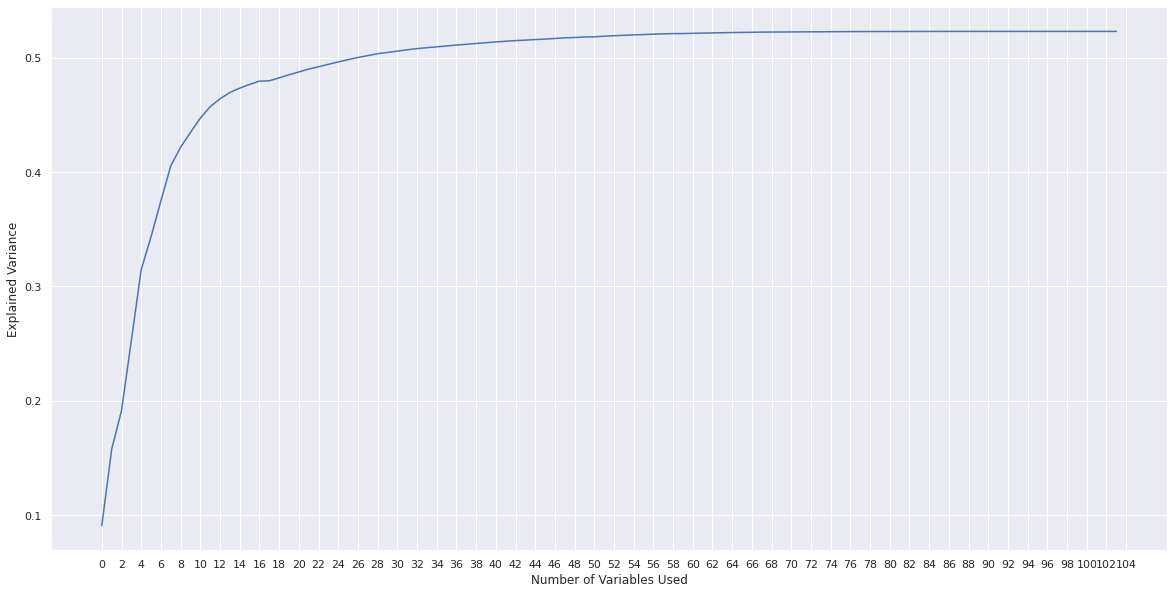

In [121]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(np.arange(len(score)),score[::-1])
ax.set_xlabel('Number of Variables Used')
ax.set_ylabel('Explained Variance')
start, end = 0,len(score)+1
ax.xaxis.set_ticks(np.arange(start, end, 2))

In [122]:
newdata.columns

Index(['A', 'cost'], dtype='object')

In [123]:
newdata = pd.concat([predictors,data["cost"]],axis=1)
score = []

for k in range(len(newdata.columns)-2):
    tup = remove(newdata)
    newdata = tup[0]
    score.append(tup[1])
    print("COUNT: ",k)

COUNT:  0
COUNT:  1
COUNT:  2
COUNT:  3
COUNT:  4
COUNT:  5
COUNT:  6
COUNT:  7
COUNT:  8
COUNT:  9
COUNT:  10
COUNT:  11
COUNT:  12
COUNT:  13
COUNT:  14
COUNT:  15
COUNT:  16
COUNT:  17
COUNT:  18
COUNT:  19
COUNT:  20
COUNT:  21
COUNT:  22
COUNT:  23
COUNT:  24
COUNT:  25
COUNT:  26
COUNT:  27
COUNT:  28
COUNT:  29
COUNT:  30
COUNT:  31
COUNT:  32
COUNT:  33
COUNT:  34
COUNT:  35
COUNT:  36
COUNT:  37
COUNT:  38
COUNT:  39
COUNT:  40
COUNT:  41
COUNT:  42
COUNT:  43
COUNT:  44
COUNT:  45
COUNT:  46
COUNT:  47
COUNT:  48
COUNT:  49
COUNT:  50
COUNT:  51
COUNT:  52
COUNT:  53
COUNT:  54
COUNT:  55
COUNT:  56
COUNT:  57
COUNT:  58
COUNT:  59
COUNT:  60
COUNT:  61
COUNT:  62
COUNT:  63
COUNT:  64
COUNT:  65
COUNT:  66
COUNT:  67
COUNT:  68
COUNT:  69
COUNT:  70
COUNT:  71
COUNT:  72
COUNT:  73
COUNT:  74
COUNT:  75
COUNT:  76
COUNT:  77
COUNT:  78
COUNT:  79
COUNT:  80
COUNT:  81
COUNT:  82
COUNT:  83
COUNT:  84
COUNT:  85
COUNT:  86
COUNT:  87
COUNT:  88
COUNT:  89
COUNT:  90
COUNT:  9

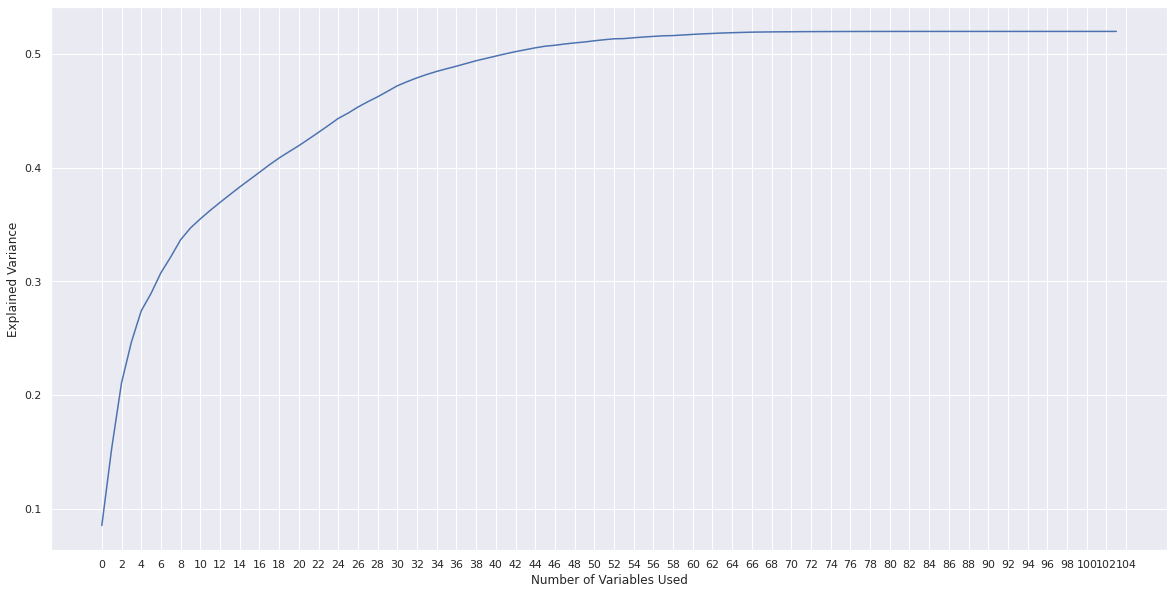

In [124]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(np.arange(len(score)),score[::-1])
ax.set_xlabel('Number of Variables Used')
ax.set_ylabel('Explained Variance')
start, end = 0,len(score)+1
ax.xaxis.set_ticks(np.arange(start, end, 2))

In [125]:
newdata = pd.concat([predictors,data["cost"]],axis=1)

for k in range(46):
    tup = remove(newdata)
    newdata = tup[0]
    print("COUNT: ",k)

COUNT:  0
COUNT:  1
COUNT:  2
COUNT:  3
COUNT:  4
COUNT:  5
COUNT:  6
COUNT:  7
COUNT:  8
COUNT:  9
COUNT:  10
COUNT:  11
COUNT:  12
COUNT:  13
COUNT:  14
COUNT:  15
COUNT:  16
COUNT:  17
COUNT:  18
COUNT:  19
COUNT:  20
COUNT:  21
COUNT:  22
COUNT:  23
COUNT:  24
COUNT:  25
COUNT:  26
COUNT:  27
COUNT:  28
COUNT:  29
COUNT:  30
COUNT:  31
COUNT:  32
COUNT:  33
COUNT:  34
COUNT:  35
COUNT:  36
COUNT:  37
COUNT:  38
COUNT:  39
COUNT:  40
COUNT:  41
COUNT:  42
COUNT:  43
COUNT:  44
COUNT:  45


In [126]:
newdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 84359 to 405845
Data columns (total 60 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   car_value                            10000 non-null  int64  
 1   A                                    10000 non-null  int64  
 2   B                                    10000 non-null  int64  
 3   C                                    10000 non-null  int64  
 4   D                                    10000 non-null  int64  
 5   E                                    10000 non-null  int64  
 6   F                                    10000 non-null  int64  
 7   G                                    10000 non-null  int64  
 8   homeowner                            10000 non-null  int64  
 9   car_age                              10000 non-null  int64  
 10  married_couple                       10000 non-null  int64  
 11  shopping_pt-shopping_pt

In [127]:
newdata = pd.concat([predictors,newloc],axis=1)

In [128]:
predictors = pd.concat([predictors,newloc],axis=1)

In [129]:
newdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417447 entries, 0 to 417446
Columns: 188 entries, car_value to x0_82
dtypes: float64(158), int64(30)
memory usage: 598.8 MB


Intercept of Regression 	: b =  [-11445372.72948855]
Coefficients of Regression 	: a =  [[ 3.43131587e+00  1.23455688e+01  2.45464135e+00  3.19848882e+00
  -6.24377675e-01  1.29408891e+01  3.94862942e+00  1.34482591e+00
  -3.31302104e+08 -6.13794202e+08 -1.27015938e+01 -1.38275069e+09
   1.71117208e+09  3.53070692e+08 -3.11208677e+08 -5.18639154e+00
   5.64392000e+07  2.50935890e+07 -9.69561384e-02  4.99731394e-02
  -2.22921326e-02  2.31647725e-02  9.02304197e-03 -1.14443123e-02
   2.09735215e-01  4.24020781e-02 -1.62575219e+00 -7.56561676e-02
  -1.27276225e+00  4.25302203e-01 -5.33501244e-01 -1.40862135e-01
   1.38117044e-01  3.08621228e-02 -2.17033505e-01  3.56292725e-03
  -1.51336193e-03  2.40914822e-02 -7.41493702e-03 -2.29850128e+00
   3.90511751e-02  1.26695633e-03  3.00598219e-01  3.05352658e-02
   1.26400916e-03  2.12607980e-02 -2.69605815e-02  4.93526459e-05
   1.08167790e-02  5.64643512e-02  9.49478149e-03  8.15441284e-01
   1.80943698e-01  1.51501074e-01  6.62604209e+08  1.2

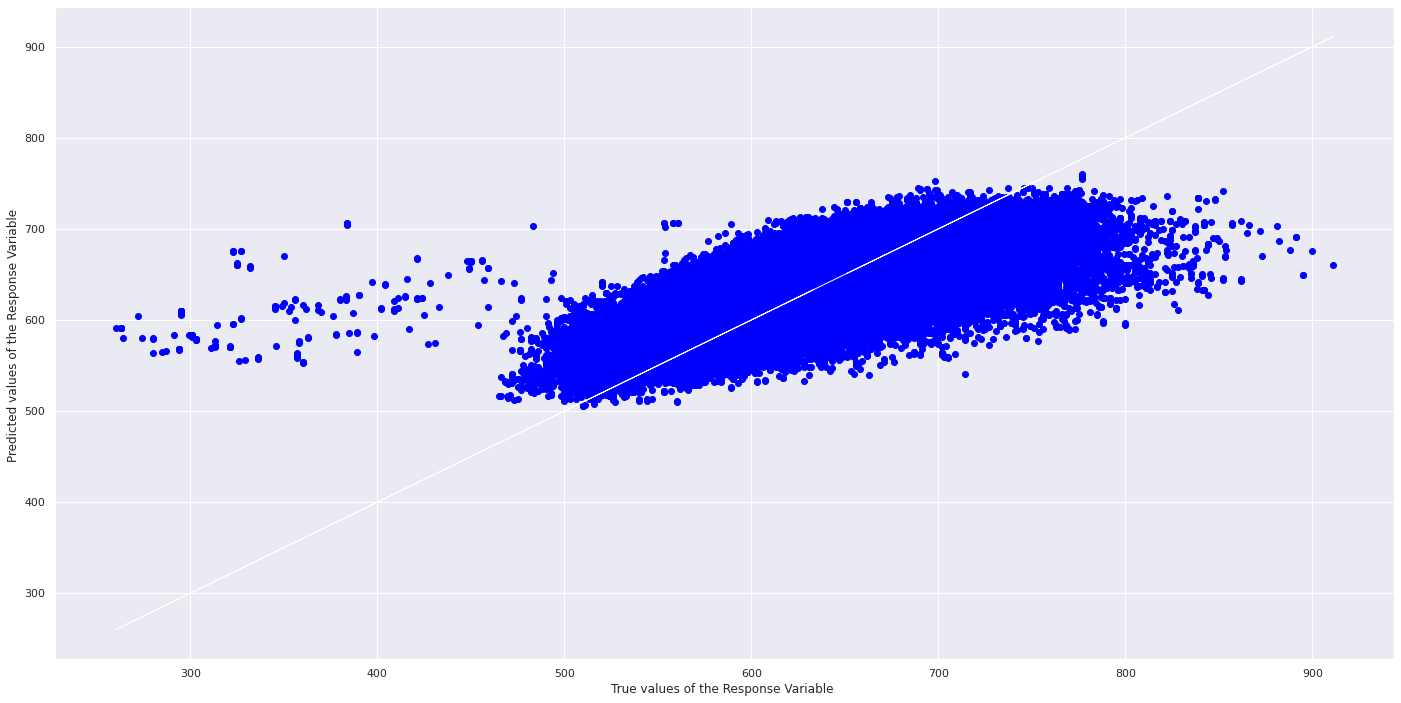

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.5097540393860169
Mean Squared Error (MSE) 	: 1047.2724982093875



In [130]:
array = []
for i in newdata.columns:
    if i!="cost":
            array.append(i)

y = pd.DataFrame(data["cost"])
X = pd.DataFrame(predictors[array])


# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X, y)                    # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Response corresponding to Predictors
y_pred = linreg.predict(X)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 1, figsize=(24, 12))
plt.scatter(y, y_pred, color = "blue")
plt.plot(y, y, 'w-', linewidth = 1)
axes.set_xlabel("True values of the Response Variable ")
axes.set_ylabel("Predicted values of the Response Variable ")
plt.show()

# Check the Goodness of Fit 
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X, y))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y, y_pred))
print()

In [131]:
newset = (y - y_pred)**2

<AxesSubplot:>

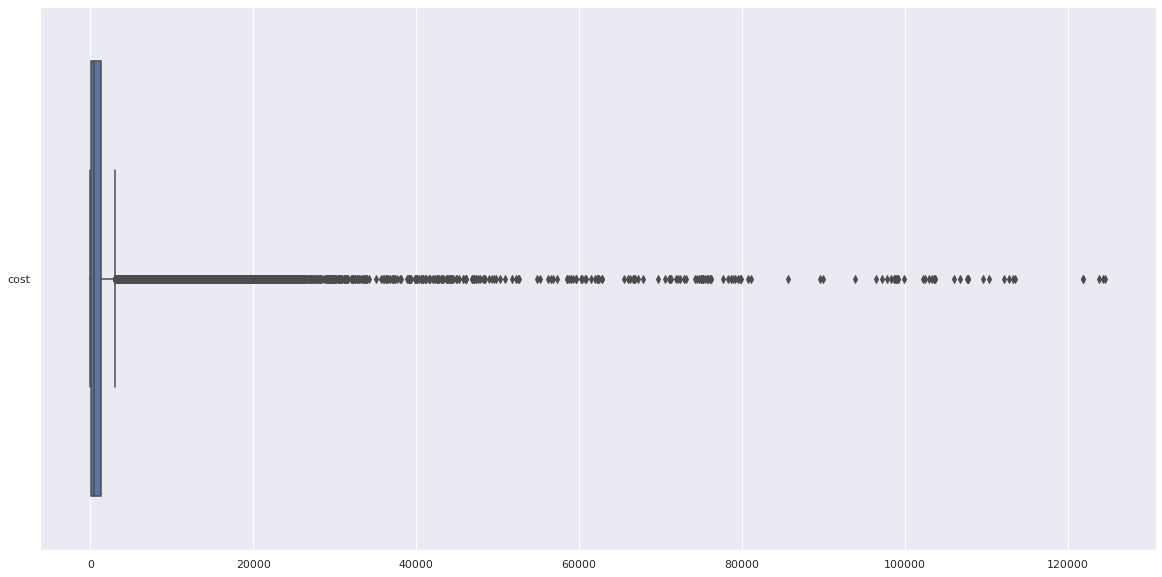

In [132]:
f = plt.figure(figsize=(20,10))
sb.boxplot(data=newset, orient='h')

In [133]:
count = 0
q1 = newset["cost"].quantile(0.25)
q3 = newset["cost"].quantile(0.75)
iqr = q3-q1
arr = []

for i in range(21):
    count = 0
    for j in newset["cost"].index:
        if newset.loc[j,"cost"] > q3 + i*iqr :
            #data = data.drop(j,axis=0)
            count = count + 1
    arr.append(count)
    print("ITERATION: ",i,arr[i])

ITERATION:  0 104362
ITERATION:  1 48714
ITERATION:  2 25067
ITERATION:  3 13960
ITERATION:  4 8432
ITERATION:  5 5646
ITERATION:  6 3999
ITERATION:  7 2944
ITERATION:  8 2248
ITERATION:  9 1822
ITERATION:  10 1503
ITERATION:  11 1224
ITERATION:  12 1013
ITERATION:  13 880
ITERATION:  14 758
ITERATION:  15 666
ITERATION:  16 604
ITERATION:  17 542
ITERATION:  18 479
ITERATION:  19 422
ITERATION:  20 366


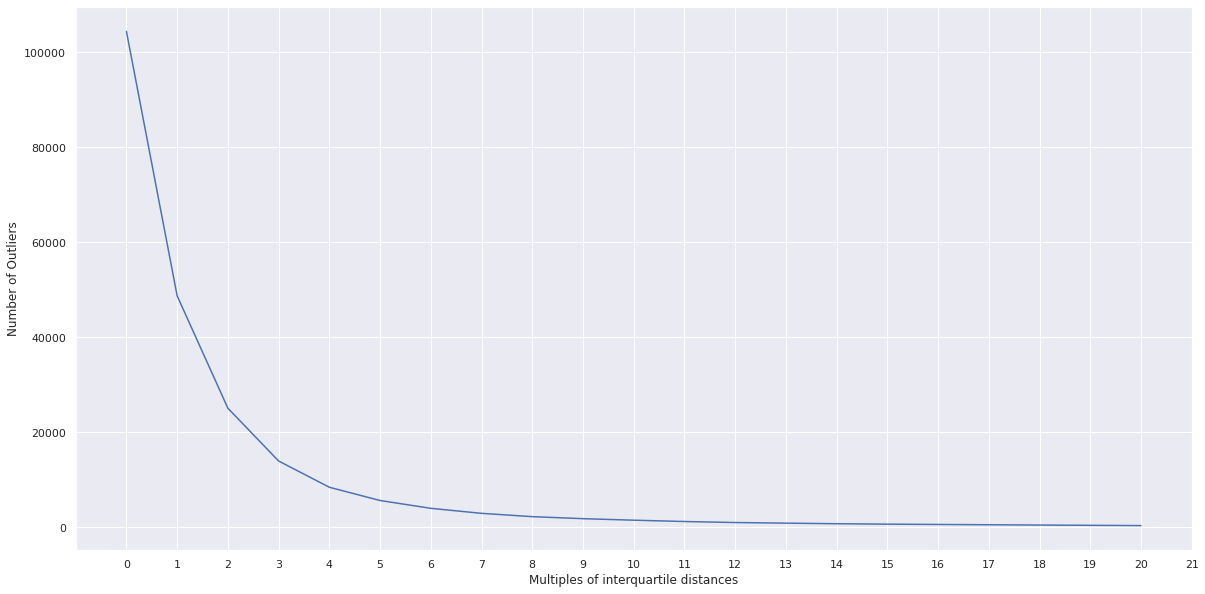

In [134]:
f, ax = plt.subplots(figsize=(20,10))
ax.plot(np.arange(len(arr)),arr)
ax.set_xlabel('Multiples of interquartile distances')
ax.set_ylabel('Number of Outliers')
start, end = 0,len(arr)+1
ax.xaxis.set_ticks(np.arange(start, end, 1))

In [135]:
newset = newset.rename(columns= {"cost":"error"})

In [136]:
df = pd.concat([newset,predictors],axis=1)
df = pd.concat([df,data["cost"]],axis=1)

q1 = df["error"].quantile(0.25)
q3 = df["error"].quantile(0.75)
iqr = q3-q1
arr = []

for i in range(21):
    temp = df[df["error"]< q3+i*iqr]
    
    y = pd.DataFrame(temp["cost"])
    X = pd.DataFrame(temp[predictors.columns])
    
    linreg.fit(X,y)
    
    arr.append(linreg.score(X,y))
    
    print("ITERATION: ",i, arr[i])

ITERATION:  0 0.7636770502219612
ITERATION:  1 0.6657515779094343
ITERATION:  2 0.6115221248716671
ITERATION:  3 0.5802362406882874
ITERATION:  4 0.5616311075117493
ITERATION:  5 0.550792412136113
ITERATION:  6 0.5436503644312156
ITERATION:  7 0.5383569660279244
ITERATION:  8 0.5345379585560854
ITERATION:  9 0.5319503992781676
ITERATION:  10 0.5297495715636993
ITERATION:  11 0.5276462429425369
ITERATION:  12 0.5257951702237821
ITERATION:  13 0.5245519800576977
ITERATION:  14 0.5232880835110884
ITERATION:  15 0.5223526777667242
ITERATION:  16 0.521719604681439
ITERATION:  17 0.5210140344834164
ITERATION:  18 0.5202148936134277
ITERATION:  19 0.5195174398277971
ITERATION:  20 0.5186877278660096


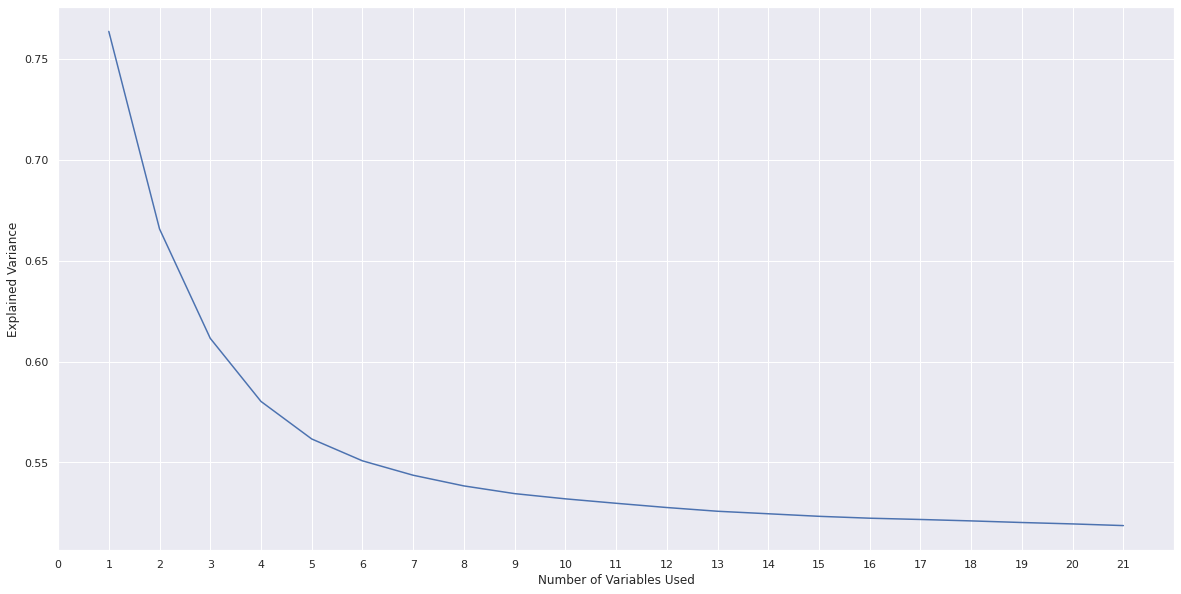

In [137]:
f, ax = plt.subplots(figsize=(20,10))
ax.plot(np.arange(len(arr),0,-1),arr[::-1])
ax.set_xlabel('Number of Variables Used')
ax.set_ylabel('Explained Variance')
start, end = 0, len(arr)+1
ax.xaxis.set_ticks(np.arange(start, end, 1))

Intercept of Regression 	: b =  [1248402.10295852]
Coefficients of Regression 	: a =  [[ 3.43293390e+00  1.19681580e+01  2.69381801e+00  3.01244446e+00
  -3.13852951e-01  1.31846831e+01  4.10813766e+00  1.86963278e+00
   1.35009811e+08  4.42240021e+08 -1.26854311e+01  9.25632986e+07
  -6.78842585e+08  3.26274291e+08  1.58286077e+07 -5.23138336e+00
  -1.93362659e+07  7.22217620e+06 -1.12378968e-01  3.76887568e-02
  -2.15865518e-02 -1.88055977e-02  6.21530585e-03 -1.04363331e-02
   2.05738726e-01  3.18028392e-02 -2.00643178e+00 -6.57996942e-02
  -1.02193392e+00  4.41785498e-01 -5.48414319e-01 -1.52262554e-02
   1.41153621e-01  3.39741409e-02 -2.78044462e-01  3.86923552e-03
  -1.01739168e-03  2.52914578e-02 -5.20169735e-03 -2.26044394e+00
   1.61938369e-02  3.21501195e-02  1.66596008e-01  4.46760654e-02
  -2.21575797e-03  2.34314799e-02 -2.36695856e-02 -1.13427639e-03
   1.04296207e-02  6.64474294e-02  9.24471021e-03  5.66527184e-01
   1.93136349e-01  1.51654154e-01 -2.70019621e+08 -8.844

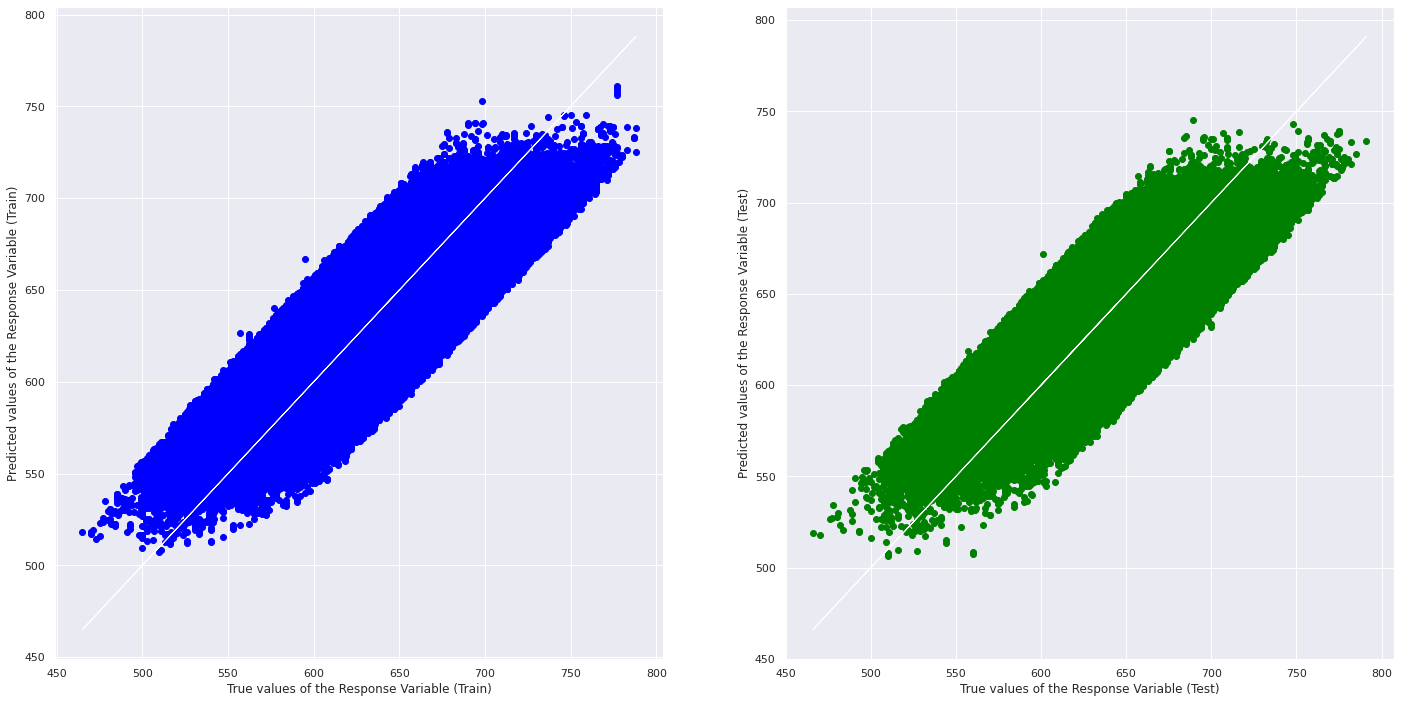

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.6190360981940559
Mean Squared Error (MSE) 	: 664.1963682062668

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6230128928049334
Mean Squared Error (MSE) 	: 665.8484046644862



In [138]:
df = pd.concat([newset,predictors],axis=1)
df = pd.concat([df,data["cost"]],axis=1)

q1 = df["error"].quantile(0.25)
q3 = df["error"].quantile(0.75)
iqr = q3-q1
arr = []
temp = df[df["error"]< q3+1.80*iqr]
    
y = pd.DataFrame(temp["cost"])
X = pd.DataFrame(temp[predictors.columns])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

# Predict Response corresponding to Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

In [139]:
percent = (int(data.cost.count())-int(y.count()))/int(data.cost.count())*100
print("Values discarded: {0:.2f}%".format(percent))

Values discarded: 6.82%


# Chi-squared Tests

We now carry out Chi-squared tests to check the dependencies of the variables in our dataset with one another. This will prove to be important in next section wherin we use these results to create a better classification model.

In [140]:
rf_a_ct = pd.crosstab(index = data['risk_factor'], columns = data['A'])
rf_a_ct

A,0,1,2
risk_factor,,,
1.0,12490,73839,12143
2.0,14642,67134,14005
3.0,26648,71037,16877
4.0,23620,69452,15560


In [141]:
rf_a_ct.iloc[0].values

array([12490, 73839, 12143])

In [142]:
(chi2, p, dof,_) = chi2_contingency([rf_a_ct.iloc[2].values,rf_a_ct.iloc[0].values,rf_a_ct.iloc[1].values,rf_a_ct.iloc[3].values])

In [143]:
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

X^2 =  6250.137802863069
p =  0.0
Degrees of freedom =  6
significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [144]:
rf_b_ct = pd.crosstab(index = data['risk_factor'], columns = data['B'])
print(rf_b_ct)
(chi2, p, dof,_) = chi2_contingency([rf_b_ct.iloc[2].values,rf_b_ct.iloc[0].values,rf_b_ct.iloc[1].values,rf_b_ct.iloc[3].values])
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

B                0      1
risk_factor              
1.0          51303  47169
2.0          51291  44490
3.0          62191  52371
4.0          57926  50706
X^2 =  103.80795898520732
p =  2.3581330177959676e-22
Degrees of freedom =  3
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [145]:
rf_c_ct = pd.crosstab(index = data['risk_factor'], columns = data['C'])
print(rf_c_ct)
(chi2, p, dof,_) = chi2_contingency([rf_c_ct.iloc[2].values,rf_c_ct.iloc[0].values,rf_c_ct.iloc[1].values,rf_c_ct.iloc[3].values])
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

C                1      2      3      4
risk_factor                            
1.0          17148  14493  49787  17044
2.0          18836  16664  47454  12827
3.0          32919  23127  48238  10278
4.0          29396  25576  46198   7462
X^2 =  13655.586433051223
p =  0.0
Degrees of freedom =  9
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [146]:
rf_d_ct = pd.crosstab(index = data['risk_factor'], columns = data['D'])
print(rf_c_ct)
(chi2, p, dof,_) = chi2_contingency([rf_d_ct.iloc[2].values,rf_d_ct.iloc[0].values,rf_d_ct.iloc[1].values,rf_d_ct.iloc[3].values])
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

C                1      2      3      4
risk_factor                            
1.0          17148  14493  49787  17044
2.0          18836  16664  47454  12827
3.0          32919  23127  48238  10278
4.0          29396  25576  46198   7462
X^2 =  7793.601804045944
p =  0.0
Degrees of freedom =  6
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [147]:
rf_e_ct = pd.crosstab(index = data['risk_factor'], columns = data['E'])
print(rf_c_ct)
(chi2, p, dof,_) = chi2_contingency([rf_e_ct.iloc[2].values,rf_e_ct.iloc[0].values,rf_e_ct.iloc[1].values,rf_e_ct.iloc[3].values])
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

C                1      2      3      4
risk_factor                            
1.0          17148  14493  49787  17044
2.0          18836  16664  47454  12827
3.0          32919  23127  48238  10278
4.0          29396  25576  46198   7462
X^2 =  5007.0861991131405
p =  0.0
Degrees of freedom =  3
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [148]:
rf_f_ct = pd.crosstab(index = data['risk_factor'], columns = data['F'])
print(rf_c_ct)
(chi2, p, dof,_) = chi2_contingency([rf_f_ct.iloc[2].values,rf_f_ct.iloc[0].values,rf_f_ct.iloc[1].values])
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

C                1      2      3      4
risk_factor                            
1.0          17148  14493  49787  17044
2.0          18836  16664  47454  12827
3.0          32919  23127  48238  10278
4.0          29396  25576  46198   7462
X^2 =  831.4093767468589
p =  2.514067981614528e-176
Degrees of freedom =  6
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [149]:
rf_g_ct = pd.crosstab(index = data['risk_factor'], columns = data['G'])
print(rf_c_ct)
(chi2, p, dof,_) = chi2_contingency([rf_g_ct.iloc[2].values,rf_g_ct.iloc[0].values,rf_g_ct.iloc[1].values,rf_g_ct.iloc[3].values])
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

C                1      2      3      4
risk_factor                            
1.0          17148  14493  49787  17044
2.0          18836  16664  47454  12827
3.0          32919  23127  48238  10278
4.0          29396  25576  46198   7462
X^2 =  17762.792912709414
p =  0.0
Degrees of freedom =  9
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [150]:
state_a_ct = pd.crosstab(index = data['state'], columns = data['A'])
print(state_a_ct)

A          0      1      2
state                     
AL      2373   6601    909
AR       937   1691    526
CO      1895   7022   2059
CT      1476   5089    574
DC       307    678     93
DE      1006   2605    361
FL     10463  82192  11107
GA       983   2487    558
IA       300   1188    209
ID      1846   3357    545
IN      6114  14075   3486
KS       392   1706    344
KY      1610   3022    596
MD      6616  19112   1829
ME       498   1651    126
MO       839   4032    645
MS       942   2134    335
MT       434    749    328
ND       130    262     64
NE       349   1102    153
NH       504   2543    230
NM       840   1727    432
NV       962   3121   2165
NY     18484  51751  19099
OH      2848  11225   1583
OK      1288   2201   1239
OR      1529   5583    681
PA      4262  19056   2876
RI       741   2116    238
SD        33    137     36
TN      1317   5067    809
UT      1178   3508    917
WA      2313   9168   1620
WI       800   2054   1411
WV       595   1173    312
W

In [151]:
data.state.nunique()

36

In [152]:
table = [state_a_ct.iloc[i].values for i in range(36)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

X^2 =  23861.07186949095
p =  0.0
Degrees of freedom =  70
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [153]:
state_b_ct = pd.crosstab(index = data['state'], columns = data['B'])
print(state_b_ct)
table = [state_b_ct.iloc[i].values for i in range(36)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

B          0      1
state              
AL      2861   7022
AR      1376   1778
CO      5885   5091
CT      5417   1722
DC       565    513
DE      2107   1865
FL     55109  48653
GA      1759   2269
IA      1060    637
ID      2674   3074
IN     11875  11800
KS      1238   1204
KY      3181   2047
MD     13117  14440
ME      1763    512
MO      3071   2445
MS      1337   2074
MT       869    642
ND       373     83
NE       974    630
NH      2027   1250
NM      1916   1083
NV      2733   3515
NY     50316  39018
OH      8614   7042
OK      3199   1529
OR      3915   3878
PA     16245   9949
RI      2169    926
SD       131     75
TN      2209   4984
UT      2018   3585
WA      6860   6241
WI      2553   1712
WV       916   1164
WY       279    284
X^2 =  10534.563970942318
p =  0.0
Degrees of freedom =  35
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [154]:
state_c_ct = pd.crosstab(index = data['state'], columns = data['C'])
print(state_c_ct)
table = [state_c_ct.iloc[i].values for i in range(36)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

C          1      2      3      4
state                            
AL      2059   2493   4119   1212
AR      1301    932    684    237
CO      1818   1572   5867   1719
CT      1534    872   3673   1060
DC       301    213    389    175
DE      1952    434   1296    290
FL     37405  16157  37968  12232
GA       115   1777   1648    488
IA       133    185   1089    290
ID      1731   1564   2158    295
IN      2967   9587  10080   1041
KS       141    450   1538    313
KY      2045   1254   1596    333
MD      6880   7483  11751   1443
ME         0    556   1402    317
MO       873   1236   2895    512
MS      2209    526    539    137
MT       391    288    643    189
ND        24     59    311     62
NE       148    171   1008    277
NH       302    175   2139    661
NM      1377    662    650    310
NV      2456    881   2302    609
NY      9882  12989  53191  13272
OH      2669   1869   9602   1516
OK      2143   1434    873    278
OR      1380   1763   3608   1042
PA      6736  

In [155]:
state_d_ct = pd.crosstab(index = data['state'], columns = data['D'])
print(state_d_ct)
table = [state_d_ct.iloc[i].values for i in range(36)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

D         1      2      3
state                    
AL     1583   3206   5094
AR     1199    989    966
CO      813   1148   9015
CT      689    752   5698
DC      202    205    671
DE     1561    542   1869
FL     8911  20606  74245
GA      116   2096   1816
IA       91    102   1504
ID     1126   1777   2845
IN     2145   6840  14690
KS      130    289   2023
KY      845   1423   2960
MD     5800   7276  14481
ME       54    377   1844
MO      509    930   4077
MS     1451   1197    763
MT      204    337    970
ND       13     61    382
NE      131    109   1364
NH      116    280   2881
NM     1051    889   1059
NV      988   1290   3970
NY     4798  14028  70508
OH     1398   1657  12601
OK     1087   1765   1876
OR      870   1771   5152
PA     3541   5432  17221
RI      583    614   1898
SD        4     21    181
TN     1296   2571   3326
UT      555   1254   3794
WA     1851   3516   7734
WI      155    286   3824
WV      628    623    829
WY       34     77    452
X^2 =  39491

In [156]:
state_e_ct = pd.crosstab(index = data['state'], columns = data['E'])
print(state_e_ct)
table = [state_e_ct.iloc[i].values for i in range(36)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

E          0      1
state              
AL      5900   3983
AR      1890   1264
CO      7299   3677
CT      2882   4257
DC       605    473
DE      1977   1995
FL     44512  59250
GA      1847   2181
IA      1356    341
ID      4765    983
IN     14842   8833
KS      1524    918
KY      3249   1979
MD     12217  15340
ME      1262   1013
MO      3634   1882
MS      1791   1620
MT      1143    368
ND       413     43
NE      1197    407
NH      1540   1737
NM      2059    940
NV      2796   3452
NY     42365  46969
OH      8573   7083
OK      3328   1400
OR      5103   2690
PA     11611  14583
RI      1252   1843
SD       157     49
TN      3046   4147
UT      3584   2019
WA      8369   4732
WI      3111   1154
WV      1221    859
WY       384    179
X^2 =  16621.154487142732
p =  0.0
Degrees of freedom =  35
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [157]:
state_f_ct = pd.crosstab(index = data['state'], columns = data['F'])
print(state_f_ct)
table = [state_f_ct.iloc[i].values for i in range(36)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

F          0      1      2     3
state                           
AL      2233   2566   4558   526
AR       888    725   1241   300
CO      1782   2593   5654   947
CT      6968     55    106    10
DC       271    308    450    49
DE       932    988   1892   160
FL      8813  29595  58741  6613
GA       914   1227   1652   235
IA       264    344    921   168
ID      1749   1765   2000   234
IN      5572   4516  12555  1032
KS       370    387   1440   245
KY      1449    784   2595   400
MD      5698   8911  12265   683
ME       432   1279    515    49
MO       777   1451   2946   342
MS       901   1018   1328   164
MT       409    256    609   237
ND       139     75    200    42
NE       316    254    920   114
NH       406   1699   1102    70
NM       819    925   1108   147
NV       898   2401   2593   356
NY     88313    291    391   339
OH      2230   5116   7622   688
OK      1236    622   2235   635
OR      1265   4263   2022   243
PA      3482  12223   9903   586
RI       6

In [158]:
state_g_ct = pd.crosstab(index = data['state'], columns = data['G'])
print(state_g_ct)
table = [state_g_ct.iloc[i].values for i in range(36)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

G          1      2      3      4
state                            
AL      2307   4851   1362   1363
AR      1293   1266    238    357
CO      3932   4294   2226    524
CT      4492   1752    311    584
DC       157    334    296    291
DE      1467   1353    498    654
FL         0   2676  82958  18128
GA       587   1780    713    948
IA       278   1094    237     88
ID      1319   2774   1136    519
IN     12605   7200   2330   1540
KS       676   1387    247    132
KY      2507   1864    544    313
MD      5883  12719   5386   3569
ME       973    794     55    453
MO       950   3693    500    373
MS       962   1854    200    395
MT       396    655    336    124
ND         0    456      0      0
NE       637    552    247    168
NH      1773    798    421    285
NM       588   1407    504    500
NV      1317   1323   3084    524
NY      9530  63679   9842   6283
OH         0   3410  10910   1336
OK       295   3087    836    510
OR      1336   3759   2040    658
PA      5681  

In [159]:
data['car_value'].nunique()

9

In [160]:
car_a_ct = pd.crosstab(index = data['car_value'], columns = data['A'])
print(car_a_ct)
table = [car_a_ct.iloc[i].values for i in range(9)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print("Significance level =",alpha, ",p =",p)
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

A              0      1      2
car_value                     
a            402    170     44
b            492    204     16
c           6079   4973    859
d          17699  43428   8156
e          26136  91201  17689
f          16938  80201  16306
g           7382  45474  10625
h           2028  14044   4034
i            244   1767    856
X^2 =  18009.669569367834
p =  0.0
Degrees of freedom =  16
Significance level = 0.010000000000000009 ,p = 0.0
Dependent (reject H0)


In [161]:
car_b_ct = pd.crosstab(index = data['car_value'], columns = data['B'])
print(car_b_ct)
table = [car_b_ct.iloc[i].values for i in range(9)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

B              0      1
car_value              
a            428    188
b            489    223
c           7350   4561
d          38627  30656
e          72235  62791
f          59331  54114
g          32567  30914
h          10231   9875
i           1453   1414
X^2 =  842.3758216103759
p =  1.5093429950748497e-176
Degrees of freedom =  8
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [162]:
car_c_ct = pd.crosstab(index = data['car_value'], columns = data['C'])
print(car_c_ct)
table = [car_c_ct.iloc[i].values for i in range(9)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

C              1      2      3      4
car_value                            
a            216    123    206     71
b            281    136    246     49
c           3990   2857   4361    703
d          20532  15357  28647   4747
e          34505  26988  61142  12391
f          23609  21187  55567  13082
g          11452  10190  30803  11036
h           3290   2764   9472   4580
i            424    258   1233    952
X^2 =  13536.915958303114
p =  0.0
Degrees of freedom =  24
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [163]:
car_d_ct = pd.crosstab(index = data['car_value'], columns = data['D'])
print(car_d_ct)
table = [car_d_ct.iloc[i].values for i in range(9)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

D              1      2      3
car_value                     
a            153    134    329
b            178    209    325
c           2009   3234   6668
d           9244  16440  43599
e          16196  28626  90204
f          11314  22810  79321
g           5599  11370  46512
h           1630   3172  15304
i            205    341   2321
X^2 =  4005.950272463576
p =  0.0
Degrees of freedom =  16
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [164]:
car_e_ct = pd.crosstab(index = data['car_value'], columns = data['E'])
print(car_e_ct)
table = [car_e_ct.iloc[i].values for i in range(9)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

E              0      1
car_value              
a            547     69
b            654     58
c           8733   3178
d          39316  29967
e          70187  64839
f          54997  58448
g          28488  34993
h           8660  11446
i           1222   1645
X^2 =  5996.654827257384
p =  0.0
Degrees of freedom =  8
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [165]:
car_f_ct = pd.crosstab(index = data['car_value'], columns = data['F'])
print(car_f_ct)
table = [car_f_ct.iloc[i].values for i in range(9)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

F              0      1      2     3
car_value                           
a            324    130    108    54
b            469    121    119     3
c           6449   2137   3005   320
d          26199  15781  24868  2435
e          46857  32869  49856  5444
f          37146  29289  42459  4551
g          21003  15254  24267  2957
h           6209   5046   7638  1213
i            937    458   1219   253
X^2 =  3703.0564733657206
p =  0.0
Degrees of freedom =  24
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [166]:
car_g_ct = pd.crosstab(index = data['car_value'], columns = data['G'])
print(car_g_ct)
table = [car_g_ct.iloc[i].values for i in range(9)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

G              1      2      3      4
car_value                            
a             95    359    131     31
b            112    365    163     72
c           2273   5020   3509   1109
d          12443  26743  23040   7057
e          23990  50529  45612  14895
f          18967  42056  38522  13900
g           9566  23118  22346   8451
h           2793   7046   7496   2771
i            414    852   1234    367
X^2 =  1507.8392981577365
p =  4.291915463494169e-304
Degrees of freedom =  24
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [167]:
print(data.A.unique())
print(data.B.unique())
print(data.C.unique())
print(data.D.unique())
print(data.E.unique())
print(data.F.unique())
print(data.G.unique())

[1 0 2]
[0 1]
[2 3 1 4]
[2 3 1]
[1 0]
[2 0 1 3]
[2 1 3 4]


### A against B to G

In [168]:
data.A.value_counts()

1    281462
0     77400
2     58585
Name: A, dtype: int64

In [169]:
a_b_ct = pd.crosstab(index = data['A'], columns = data['B'])
print(a_b_ct)
print()
table = [a_b_ct.iloc[i].values for i in range(3)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

B       0       1
A                
0   58468   18932
1  133294  148168
2   30949   27636

X^2 =  19380.71196650664
p =  0.0
Degrees of freedom =  2
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [170]:
a_c_ct = pd.crosstab(index = data['A'], columns = data['C'])
print(a_c_ct)
print()
table = [a_c_ct.iloc[i].values for i in range(3)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

C      1      2       3      4
A                             
0  32521  18711   22246   3922
1  53239  51154  142122  34947
2  12539   9995   27309   8742

X^2 =  25063.31718753882
p =  0.0
Degrees of freedom =  6
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [171]:
a_d_ct = pd.crosstab(index = data['A'], columns = data['D'])
print(a_d_ct)
print()
table = [a_d_ct.iloc[i].values for i in range(3)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

D      1      2       3
A                      
0  19729  20281   37390
1  21455  54992  205015
2   5344  11063   42178

X^2 =  24552.83938887044
p =  0.0
Degrees of freedom =  4
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [172]:
a_e_ct = pd.crosstab(index = data['A'], columns = data['E'])
print(a_e_ct)
print()
table = [a_e_ct.iloc[i].values for i in range(3)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

E       0       1
A                
0   74843    2557
1  110611  170851
2   27350   31235

X^2 =  80531.64285860011
p =  0.0
Degrees of freedom =  2
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [173]:
a_f_ct = pd.crosstab(index = data['A'], columns = data['F'])
print(a_f_ct)
print()
table = [a_f_ct.iloc[i].values for i in range(3)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

F      0      1       2      3
A                             
0  68596   4118    4184    502
1  57429  88098  135734    201
2  19568   8869   13621  16527

X^2 =  229755.27406243625
p =  0.0
Degrees of freedom =  6
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [174]:
a_g_ct = pd.crosstab(index = data['A'], columns = data['G'])
print(a_g_ct)
print()
table = [a_g_ct.iloc[i].values for i in range(3)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

G      1      2       3      4
A                             
0  14821  38345   15528   8706
1  45623  95661  106168  34010
2  10209  22082   20357   5937

X^2 =  9994.03023896656
p =  0.0
Degrees of freedom =  6
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


### B against C to G

In [175]:
ct = pd.crosstab(index = data['B'], columns = data['C'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(2)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

C      1      2      3      4
B                            
0  60318  42295  96660  23438
1  37981  37565  95017  24173

X^2 =  3522.4242506538208
p =  0.0
Degrees of freedom =  3
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [176]:
ct = pd.crosstab(index = data['B'], columns = data['D'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(2)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

D      1      2       3
B                      
0  32246  48400  142065
1  14282  37936  142518

X^2 =  6358.514905138978
p =  0.0
Degrees of freedom =  2
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [177]:
ct = pd.crosstab(index = data['B'], columns = data['E'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(2)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

E       0       1
B                
0  161395   61316
1   51409  143327

X^2 =  88231.07155324926
p =  0.0
Degrees of freedom =  1
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [178]:
ct = pd.crosstab(index = data['B'], columns = data['F'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(2)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

F      0      1      2      3
B                            
0  92899  45508  73773  10531
1  52694  55577  79766   6699

X^2 =  11367.927213939598
p =  0.0
Degrees of freedom =  3
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [179]:
ct = pd.crosstab(index = data['B'], columns = data['G'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(2)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

G      1      2      3      4
B                            
0  38083  86461  72969  25198
1  32570  69627  69084  23455

X^2 =  542.1102567745957
p =  3.5648087638228045e-117
Degrees of freedom =  3
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


### C against D to G

In [180]:
ct = pd.crosstab(index = data['C'], columns = data['D'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(4)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

D      1      2       3
C                      
1  40842  28668   28789
2   4257  37885   37718
3   1146  19146  171385
4    283    637   46691

X^2 =  203976.97959164574
p =  0.0
Degrees of freedom =  6
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [181]:
ct = pd.crosstab(index = data['C'], columns = data['E'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(4)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

E      0       1
C               
1  62923   35376
2  45603   34257
3  86006  105671
4  18272   29339

X^2 =  13767.3705501468
p =  0.0
Degrees of freedom =  3
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [182]:
ct = pd.crosstab(index = data['C'], columns = data['F'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(4)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

F      0      1      2     3
C                           
1  35796  16708  39745  6050
2  25570  19736  31421  3133
3  68094  50267  67351  5965
4  16133  14374  15022  2082

X^2 =  5901.7046811517885
p =  0.0
Degrees of freedom =  9
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [183]:
ct = pd.crosstab(index = data['C'], columns = data['G'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(4)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

G      1      2      3      4
C                            
1  17131  31569  38759  10840
2  17107  32275  23182   7296
3  30707  76239  62273  22458
4   5708  16005  17839   8059

X^2 =  6478.887066992215
p =  0.0
Degrees of freedom =  9
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


### D against E to G

In [184]:
ct = pd.crosstab(index = data['D'], columns = data['E'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(3)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

E       0       1
D                
1   34006   12522
2   49260   37076
3  129538  155045

X^2 =  13771.434258801477
p =  0.0
Degrees of freedom =  2
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [185]:
ct = pd.crosstab(index = data['D'], columns = data['F'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(3)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

F      0      1       2      3
D                             
1  21495   6204   15969   2860
2  28023  20455   33663   4195
3  96075  74426  103907  10175

X^2 =  5660.885400044669
p =  0.0
Degrees of freedom =  6
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [186]:
ct = pd.crosstab(index = data['D'], columns = data['G'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(3)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

G      1       2       3      4
D                              
1  10486   19457    9969   6616
2  16291   34623   26855   8567
3  43876  102008  105229  33470

X^2 =  5639.113782622617
p =  0.0
Degrees of freedom =  6
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


### E against F and G

In [187]:
ct = pd.crosstab(index = data['E'], columns = data['F'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(2)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

F      0      1      2      3
E                            
0  94396  39520  68466  10422
1  51197  61565  85073   6808

X^2 =  20027.646234384883
p =  0.0
Degrees of freedom =  3
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


In [188]:
ct = pd.crosstab(index = data['E'], columns = data['G'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(2)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

G      1      2      3      4
E                            
0  40299  87551  63976  20978
1  30354  68537  78077  27675

X^2 =  5880.327813465379
p =  0.0
Degrees of freedom =  3
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


### F against G

In [189]:
ct = pd.crosstab(index = data['F'], columns = data['G'])
print(ct)
print()
table = [ct.iloc[i].values for i in range(4)]
(chi2, p, dof,_) = chi2_contingency(table)
print("X^2 = ",chi2)
print("p = ",p)
print("Degrees of freedom = ", dof)
prob = 0.99
alpha = 1.0 - prob
print('Significance level = %.3f, p = %f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

G      1      2      3      4
F                            
0  25014  85349  21445  13785
1  13775  28975  43805  14530
2  28373  37262  69357  18547
3   3491   4502   7446   1791

X^2 =  54077.25290194352
p =  0.0
Degrees of freedom =  9
Significance level = 0.010, p = 0.000000
Dependent (reject H0)


<AxesSubplot:>

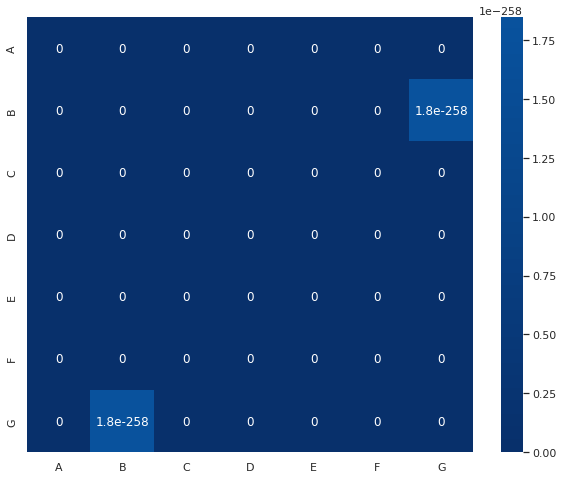

In [190]:
plt.subplots(figsize=(10,8))

table = [[0 for c in range(7)]for r in range(7)]
table[1][6] = 1.845774616064957e-258 
table[6][1] = 1.845774616064957e-258 

arr = np.array(table)
x_axis_labels = ['A','B','C','D','E','F','G']
y_axis_labels = ['A','B','C','D','E','F','G'] 
sb.heatmap(arr, cmap='Blues_r', center=7e-258, linewidth=0, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

# Random Forest Classifier

Let's go back to our central question. We wanted to predict the policy vector, i.e, the set of choices for each of the variables from A to G that a customer will pick even before he/she chooses it. 

This question cannot be solved by a simple classification model on each of these components from A...G as we have shown that they are clearly inter-dependent using the chi-squared test. However, to begin with, let's assume that each of these components are independent and make a prediction. To establish an inter-dependency we can then use the predicted values from the first set of random forests and feed these values into a second layer of random forests which uses these predicted responses along with the input to create a better prediction for each of the components.

Note that we would not be using the predicted value of a variable in the first layer to make a prediction for the same variable in the second layer, i.e. we would not use the predicted value of A to predict A' in the second layer.

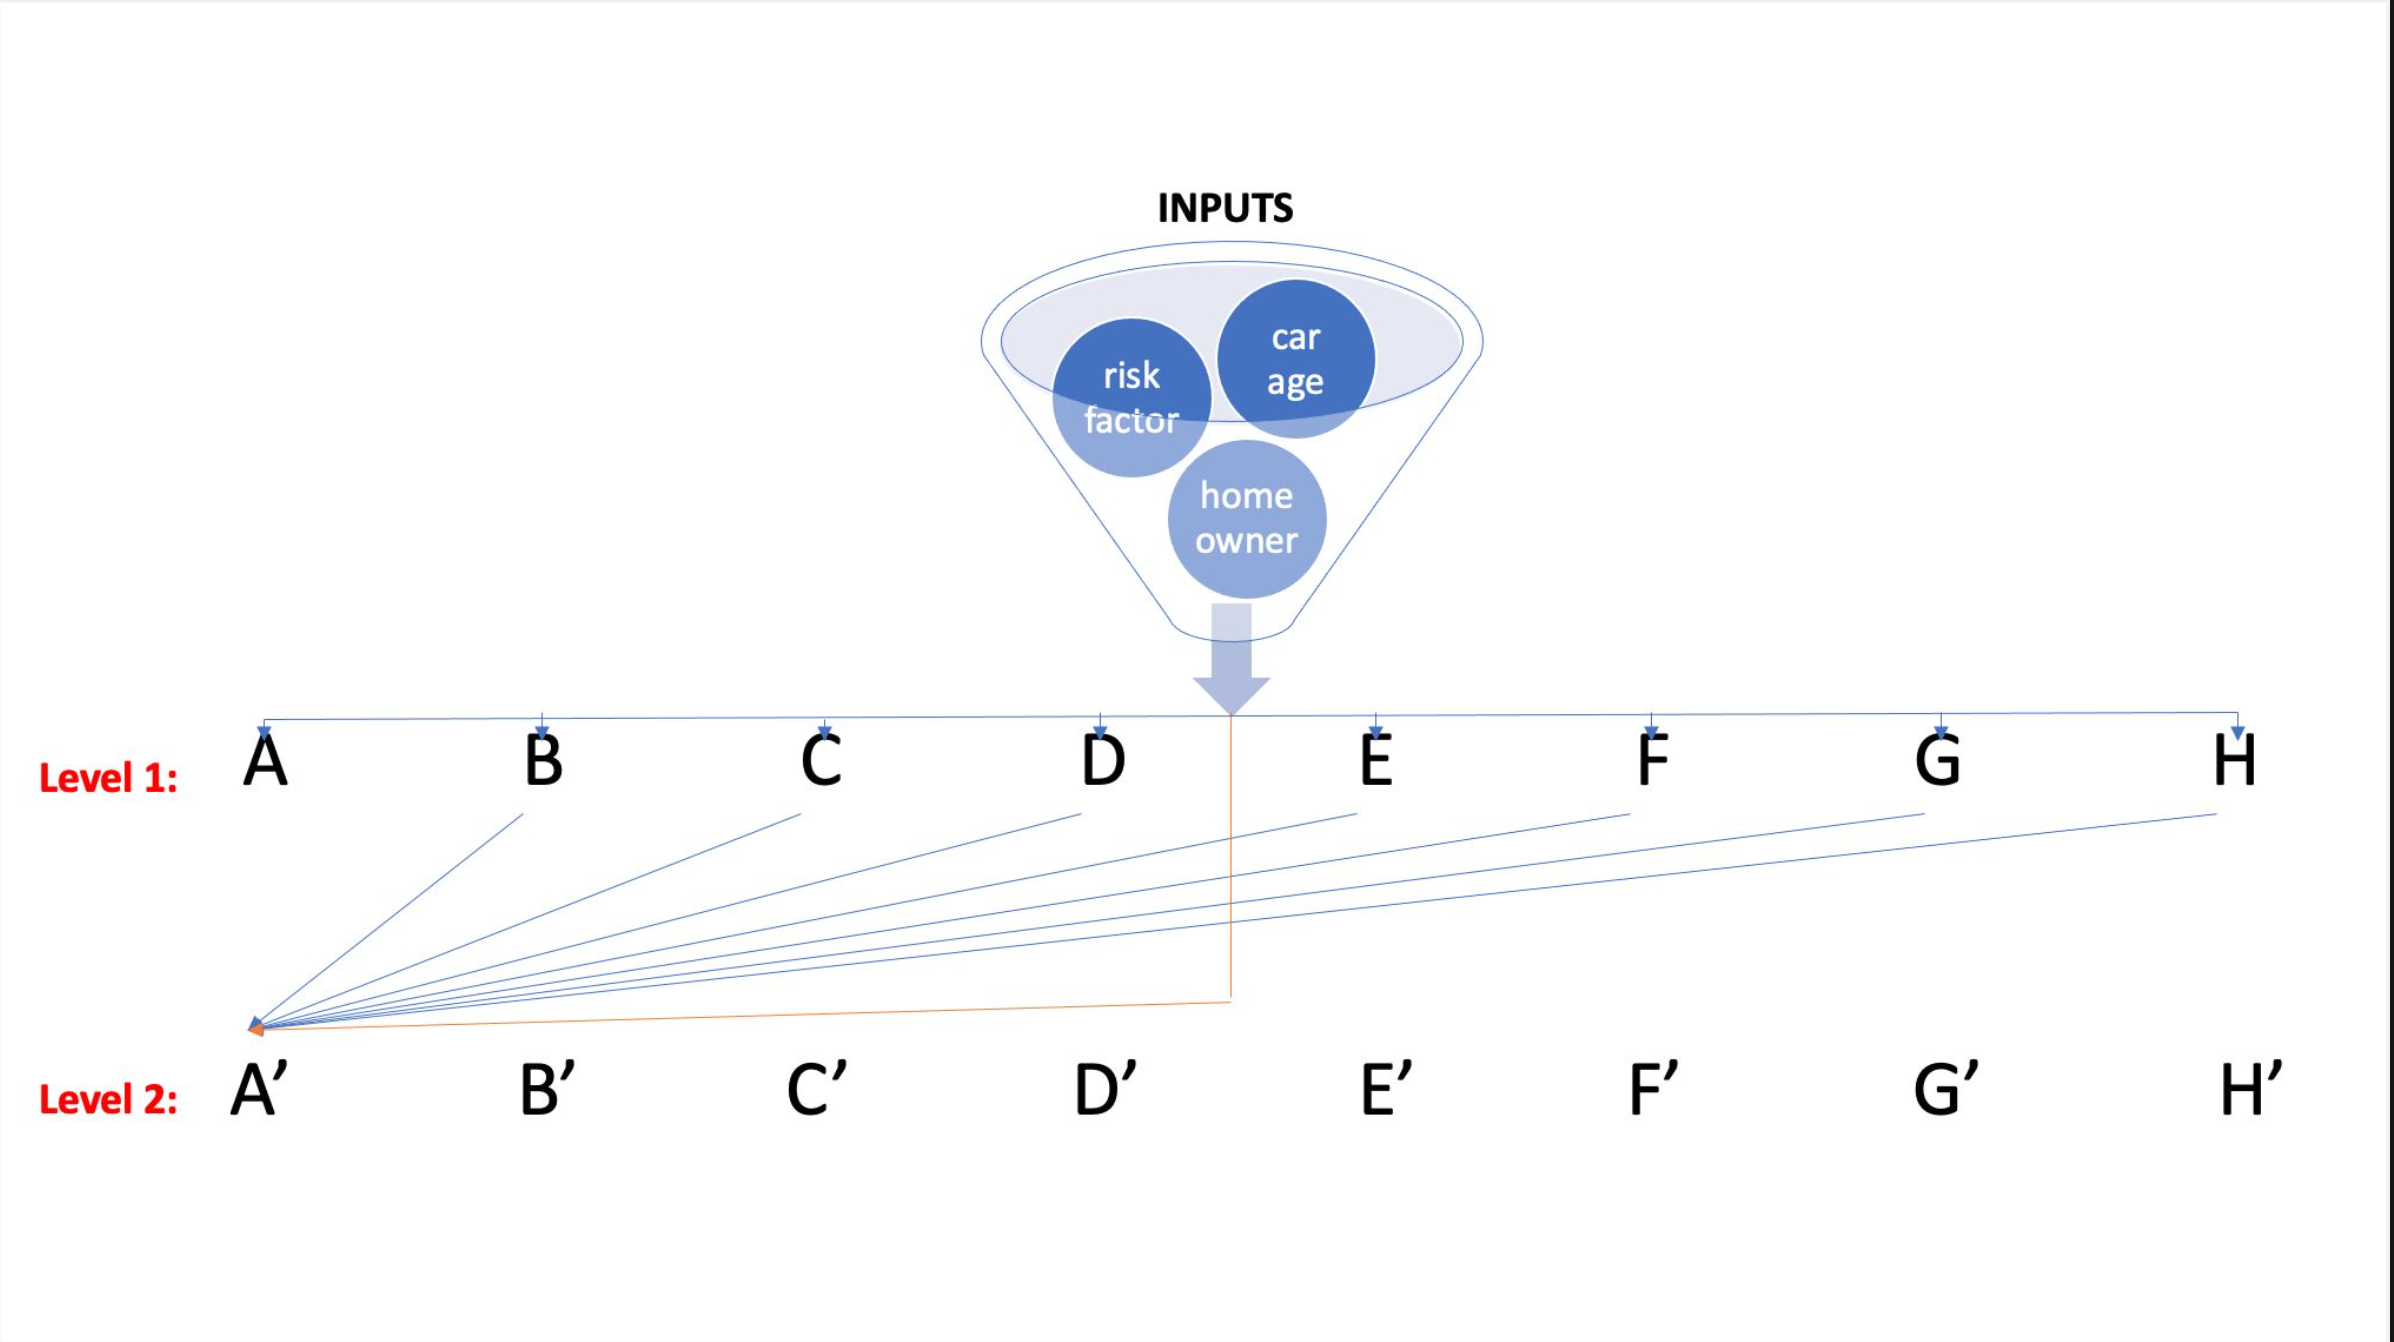

In [191]:
predictors = data[["shopping_pt","group_size","homeowner","car_age","risk_factor",       
                   "age_oldest","age_youngest","married_couple","C_previous","duration_previous","cost"]]

In [192]:
predictors.head()

,shopping_pt,group_size,homeowner,car_age,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous,cost
0,1,2,0,2,3.0,46,42,1,1.0,2.0,633
1,2,2,0,2,3.0,46,42,1,1.0,2.0,630
2,3,2,0,2,3.0,46,42,1,1.0,2.0,630
3,4,2,0,2,3.0,46,42,1,1.0,2.0,630
4,5,2,0,2,3.0,46,42,1,1.0,2.0,630


In [193]:
data.car_value

0         g
1         g
2         g
3         g
4         g
         ..
417442    g
417443    g
417444    f
417445    f
417446    g
Name: car_value, Length: 417447, dtype: object

In [194]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [195]:
le.fit(data.car_value)

LabelEncoder()

In [196]:
le.classes_

array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'], dtype=object)

In [197]:
car_val = pd.DataFrame(le.transform(data["car_value"]))
car_val.rename(columns={0:"car_value"},inplace=True)

predictors = pd.concat([car_val,predictors], axis=1)

predictors.car_value.value_counts()

4    135026
5    113445
3     69283
6     63481
7     20106
2     11911
8      2867
1       712
0       616
Name: car_value, dtype: int64

In [198]:
from sklearn.preprocessing import OneHotEncoder

In [199]:
hot = OneHotEncoder()

In [200]:
hot.fit(data[["state"]])

OneHotEncoder()

In [201]:
newstate = pd.DataFrame(hot.transform(data[["state"]]).toarray(), columns=hot.get_feature_names())

In [202]:
predictors = pd.concat([predictors,newstate],axis=1)

In [203]:
hot.fit(data[["day"]])

OneHotEncoder()

In [204]:
newday = pd.DataFrame(hot.transform(data[["day"]]).toarray(), columns=hot.get_feature_names())

predictors = pd.concat([predictors,newday],axis=1)

predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417447 entries, 0 to 417446
Data columns (total 55 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   car_value          417447 non-null  int64  
 1   shopping_pt        417447 non-null  int64  
 2   group_size         417447 non-null  int64  
 3   homeowner          417447 non-null  int64  
 4   car_age            417447 non-null  int64  
 5   risk_factor        417447 non-null  float64
 6   age_oldest         417447 non-null  int64  
 7   age_youngest       417447 non-null  int64  
 8   married_couple     417447 non-null  int64  
 9   C_previous         417447 non-null  float64
 10  duration_previous  417447 non-null  float64
 11  cost               417447 non-null  int64  
 12  x0_AL              417447 non-null  float64
 13  x0_AR              417447 non-null  float64
 14  x0_CO              417447 non-null  float64
 15  x0_CT              417447 non-null  float64
 16  x0

In [205]:
newdata = pd.concat([data[['A','B','C','D','E','F','G']],predictors], axis=1)

newdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417447 entries, 0 to 417446
Data columns (total 62 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   A                  417447 non-null  int64  
 1   B                  417447 non-null  int64  
 2   C                  417447 non-null  int64  
 3   D                  417447 non-null  int64  
 4   E                  417447 non-null  int64  
 5   F                  417447 non-null  int64  
 6   G                  417447 non-null  int64  
 7   car_value          417447 non-null  int64  
 8   shopping_pt        417447 non-null  int64  
 9   group_size         417447 non-null  int64  
 10  homeowner          417447 non-null  int64  
 11  car_age            417447 non-null  int64  
 12  risk_factor        417447 non-null  float64
 13  age_oldest         417447 non-null  int64  
 14  age_youngest       417447 non-null  int64  
 15  married_couple     417447 non-null  int64  
 16  C_

In [206]:
from sklearn.model_selection import train_test_split

sdata = newdata.sample(n = 30000)
usedata = sdata

from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [207]:
A0 = usedata[usedata.A == 0]
A1 = usedata[usedata.A == 1]
A2 = usedata[usedata.A == 2]

maxim = max( A0.shape[0], A1.shape[0], A2.shape[0] )

 
A0_up = resample(A0, replace=True, n_samples=maxim)   
A1_up = resample(A1, replace=True, n_samples=maxim)
A2_up = resample(A2, replace=True, n_samples=maxim)

usedata_up = pd.concat([A0_up, A1_up , A2_up])
 

usedata_up['A'].value_counts()

y = pd.DataFrame(usedata_up['A'])
X = pd.DataFrame(usedata_up.drop(['A','B','C','D','E','F','G'], axis = 1))

param_grid = {'n_estimators': np.arange(100,1001,100),   
              'max_depth': np.arange(2, 11)}             


rnGrid = RandomizedSearchCV(RandomForestClassifier(),   
                      param_grid,       
                      n_iter=20,
                      cv = 5,                     
                      scoring = 'f1_weighted')      


rnGrid.fit(X, y.A.ravel())

A_new = rnGrid.predict(usedata.drop(['A','B','C','D','E','F','G'],axis=1))

In [208]:
B0 = usedata[usedata.B == 0]
B1 = usedata[usedata.B == 1]

maxim = max( B0.shape[0], B1.shape[0] )

 
B0_up = resample(B0, replace=True, n_samples=maxim)   
B1_up = resample(B1, replace=True, n_samples=maxim)

usedata_up = pd.concat([B0_up, B1_up])
 

usedata_up['B'].value_counts()

y = pd.DataFrame(usedata_up['B'])
X = pd.DataFrame(usedata_up.drop(['A','B','C','D','E','F','G'], axis = 1))

param_grid = {'n_estimators': np.arange(100,1001,100),   
              'max_depth': np.arange(2, 11)}             


rnGrid = RandomizedSearchCV(RandomForestClassifier(),   
                      param_grid,       
                      n_iter=20,
                      cv = 5,                     
                      scoring = 'f1_weighted')      


rnGrid.fit(X, y.B.ravel())

B_new = rnGrid.predict(usedata.drop(['A','B','C','D','E','F','G'],axis=1))

In [209]:
C1 = usedata[usedata.C == 1]
C2 = usedata[usedata.C == 2]
C3 = usedata[usedata.C == 3]
C4 = usedata[usedata.C == 4]

maxim = max( C1.shape[0], C2.shape[0], C3.shape[0], C4.shape[0] )

 
C1_up = resample(C1, replace=True, n_samples=maxim)   
C2_up = resample(C2, replace=True, n_samples=maxim)
C3_up = resample(C3, replace=True, n_samples=maxim)
C4_up = resample(C4, replace=True, n_samples=maxim)

usedata_up = pd.concat([C1_up, C2_up, C3_up, C4_up])
 

usedata_up['C'].value_counts()

y = pd.DataFrame(usedata_up['C'])
X = pd.DataFrame(usedata_up.drop(['A','B','C','D','E','F','G'], axis = 1))

param_grid = {'n_estimators': np.arange(100,1001,100),   
              'max_depth': np.arange(2, 11)}             


rnGrid = RandomizedSearchCV(RandomForestClassifier(),   
                      param_grid,       
                      n_iter=20,
                      cv = 5,                     
                      scoring = 'f1_weighted')      


rnGrid.fit(X, y.C.ravel())

C_new = rnGrid.predict(usedata.drop(['A','B','C','D','E','F','G'],axis=1))

In [210]:
D1 = usedata[usedata.D == 1]
D2 = usedata[usedata.D == 2]
D3 = usedata[usedata.D == 3]

maxim = max( D1.shape[0], D2.shape[0], D3.shape[0] )

 
D1_up = resample(D1, replace=True, n_samples=maxim)   
D2_up = resample(D2, replace=True, n_samples=maxim)
D3_up = resample(D3, replace=True, n_samples=maxim)

usedata_up = pd.concat([D1_up, D2_up, D3_up])
 

usedata_up['D'].value_counts()

y = pd.DataFrame(usedata_up['D'])
X = pd.DataFrame(usedata_up.drop(['A','B','C','D','E','F','G'], axis = 1))

param_grid = {'n_estimators': np.arange(100,1001,100),   
              'max_depth': np.arange(2, 11)}             


rnGrid = RandomizedSearchCV(RandomForestClassifier(),   
                      param_grid,       
                      n_iter=20,
                      cv = 5,                     
                      scoring = 'f1_weighted')      


rnGrid.fit(X, y.D.ravel())

D_new = rnGrid.predict(usedata.drop(['A','B','C','D','E','F','G'],axis=1))

In [211]:
E0 = usedata[usedata.E == 0]
E1 = usedata[usedata.E == 1]

maxim = max( E0.shape[0], E1.shape[0] )

 
E0_up = resample(E0, replace=True, n_samples=maxim)   
E1_up = resample(E1, replace=True, n_samples=maxim)

usedata_up = pd.concat([E0_up, E1_up])
 

usedata_up['E'].value_counts()

y = pd.DataFrame(usedata_up['E'])
X = pd.DataFrame(usedata_up.drop(['A','B','C','D','E','F','G'], axis = 1))

param_grid = {'n_estimators': np.arange(100,1001,100),   
              'max_depth': np.arange(2, 11)}             


rnGrid = RandomizedSearchCV(RandomForestClassifier(),   
                      param_grid,       
                      n_iter=20,
                      cv = 5,                     
                      scoring = 'f1_weighted')      


rnGrid.fit(X, y.E.ravel())

E_new = rnGrid.predict(usedata.drop(['A','B','C','D','E','F','G'],axis=1))

In [212]:
F0 = usedata[usedata.F == 0]
F1 = usedata[usedata.F == 1]
F2 = usedata[usedata.F == 2]
F3 = usedata[usedata.F == 3]

maxim = max( F0.shape[0], F1.shape[0], F2.shape[0], F3.shape[0] )

 
F0_up = resample(F0, replace=True, n_samples=maxim)   
F1_up = resample(F1, replace=True, n_samples=maxim)
F2_up = resample(F2, replace=True, n_samples=maxim)
F3_up = resample(F3, replace=True, n_samples=maxim)

usedata_up = pd.concat([F0_up, F1_up , F2_up, F3_up])
 

usedata_up['F'].value_counts()

y = pd.DataFrame(usedata_up['F'])
X = pd.DataFrame(usedata_up.drop(['A','B','C','D','E','F','G'], axis = 1))

param_grid = {'n_estimators': np.arange(100,1001,100),   
              'max_depth': np.arange(2, 11)}             


rnGrid = RandomizedSearchCV(RandomForestClassifier(),   
                      param_grid,       
                      n_iter=20,
                      cv = 5,                     
                      scoring = 'f1_weighted')      


rnGrid.fit(X, y.F.ravel())

F_new = rnGrid.predict(usedata.drop(['A','B','C','D','E','F','G'],axis=1))

In [213]:
G1 = usedata[usedata.G == 1]
G2 = usedata[usedata.G == 2]
G3 = usedata[usedata.G == 3]
G4 = usedata[usedata.G == 4]

maxim = max( G1.shape[0], G2.shape[0], G3.shape[0], G4.shape[0] )

 
G1_up = resample(G1, replace=True, n_samples=maxim)   
G2_up = resample(G2, replace=True, n_samples=maxim)
G3_up = resample(G3, replace=True, n_samples=maxim)
G4_up = resample(G4, replace=True, n_samples=maxim)

usedata_up = pd.concat([G1_up, G2_up, G3_up, G4_up])
 

usedata_up['G'].value_counts()

y = pd.DataFrame(usedata_up['G'])
X = pd.DataFrame(usedata_up.drop(['A','B','C','D','E','F','G'], axis = 1))

param_grid = {'n_estimators': np.arange(100,1001,100),   
              'max_depth': np.arange(2, 11)}             


rnGrid = RandomizedSearchCV(RandomForestClassifier(),   
                      param_grid,       
                      n_iter=20,
                      cv = 5,                     
                      scoring = 'f1_weighted')      


rnGrid.fit(X, y.G.ravel())

G_new = rnGrid.predict(usedata.drop(['A','B','C','D','E','F','G'],axis=1))

In [214]:
G_ = pd.DataFrame(G_new, index=sdata.index)

F_ = pd.DataFrame(F_new, index=sdata.index)

E_ = pd.DataFrame(E_new, index=sdata.index)

D_ = pd.DataFrame(D_new, index=sdata.index)

C_ = pd.DataFrame(C_new, index=sdata.index)

B_ = pd.DataFrame(B_new, index=sdata.index)

A_ = pd.DataFrame(A_new, index=sdata.index)

In [215]:
G_.rename(columns={0:'G_new'},inplace=True)

F_.rename(columns={0:'F_new'},inplace=True)

E_.rename(columns={0:'E_new'},inplace=True)

D_.rename(columns={0:'D_new'},inplace=True)

C_.rename(columns={0:'C_new'},inplace=True)

B_.rename(columns={0:'B_new'},inplace=True)

A_.rename(columns={0:'A_new'},inplace=True)

In [216]:
usedata = pd.concat([usedata,A_,B_,C_,D_,E_,F_,G_],axis=1)

In [217]:
A0 = usedata[usedata.A == 0]
A1 = usedata[usedata.A == 1]
A2 = usedata[usedata.A == 2]

maxim = max( A0.shape[0], A1.shape[0], A2.shape[0] )

 
A0_up = resample(A0, replace=True, n_samples=maxim)   
A1_up = resample(A1, replace=True, n_samples=maxim)
A2_up = resample(A2, replace=True, n_samples=maxim)

usedata_up = pd.concat([A0_up, A1_up , A2_up])

y = pd.DataFrame(usedata_up['A'])
X = pd.DataFrame(usedata_up.drop(['A_new','A','B','C','D','E','F','G'], axis = 1))

param_grid = {'n_estimators': np.arange(400,701,100),   
              'max_depth': np.arange(8, 15)}             


rnGrid_a2 = RandomizedSearchCV(RandomForestClassifier(),   
                      param_grid,       
                      n_iter=8,
                      cv = 5,                     
                      scoring = 'f1_weighted')      


rnGrid_a2.fit(X, y.A.ravel())

A_new = rnGrid_a2.predict(usedata.drop(['A_new','A','B','C','D','E','F','G'],axis=1))
print(rnGrid_a2.best_estimator_)
print(rnGrid_a2.best_score_)

RandomForestClassifier(max_depth=14, n_estimators=400)
0.861545909822631


In [218]:
B0 = usedata[usedata.B == 0]
B1 = usedata[usedata.B == 1]

maxim = max( B0.shape[0], B1.shape[0] )

 
B0_up = resample(B0, replace=True, n_samples=maxim)   
B1_up = resample(B1, replace=True, n_samples=maxim)

usedata_up = pd.concat([B0_up, B1_up])
 

usedata_up['B'].value_counts()

y = pd.DataFrame(usedata_up['B'])
X = pd.DataFrame(usedata_up.drop(['A','B','B_new','C','D','E','F','G'], axis = 1))

param_grid = {'n_estimators': np.arange(400,801,100),   
              'max_depth': np.arange(9, 15)}             


rnGrid_b2 = RandomizedSearchCV(RandomForestClassifier(),   
                      param_grid,       
                      n_iter=10,
                      cv = 5,                     
                      scoring = 'f1_weighted')      


rnGrid_b2.fit(X, y.B.ravel())

B_new = rnGrid_b2.predict(usedata.drop(['A','B','B_new','C','D','E','F','G'],axis=1))
print(rnGrid_b2.best_estimator_)
print(rnGrid_b2.best_score_)

RandomForestClassifier(max_depth=14, n_estimators=700)
0.7468964362261309


In [219]:
C1 = usedata[usedata.C == 1]
C2 = usedata[usedata.C == 2]
C3 = usedata[usedata.C == 3]
C4 = usedata[usedata.C == 4]

maxim = max( C1.shape[0], C2.shape[0], C3.shape[0], C4.shape[0] )

 
C1_up = resample(C1, replace=True, n_samples=maxim)   
C2_up = resample(C2, replace=True, n_samples=maxim)
C3_up = resample(C3, replace=True, n_samples=maxim)
C4_up = resample(C4, replace=True, n_samples=maxim)

usedata_up = pd.concat([C1_up, C2_up, C3_up, C4_up])

y = pd.DataFrame(usedata_up['C'])
X = pd.DataFrame(usedata_up.drop(['A','B','C','C_new','D','E','F','G'], axis = 1))

param_grid = {'n_estimators': np.arange(600,1101,100),   
              'max_depth': np.arange(9, 17)}             


rnGrid_c2 = RandomizedSearchCV(RandomForestClassifier(),   
                      param_grid,       
                      n_iter=10,
                      cv = 5,                     
                      scoring = 'f1_weighted')      


rnGrid_c2.fit(X, y.C.ravel())

C_new = rnGrid_c2.predict(usedata.drop(['A','B','C','C_new','D','E','F','G'],axis=1))
print(rnGrid_c2.best_estimator_)
print(rnGrid_c2.best_score_)

RandomForestClassifier(max_depth=16, n_estimators=1000)
0.8734704260659372


In [220]:
D1 = usedata[usedata.D == 1]
D2 = usedata[usedata.D == 2]
D3 = usedata[usedata.D == 3]

maxim = max( D1.shape[0], D2.shape[0], D3.shape[0] )

 
D1_up = resample(D1, replace=True, n_samples=maxim)   
D2_up = resample(D2, replace=True, n_samples=maxim)
D3_up = resample(D3, replace=True, n_samples=maxim)

usedata_up = pd.concat([D1_up, D2_up, D3_up])

y = pd.DataFrame(usedata_up['D'])
X = pd.DataFrame(usedata_up.drop(['A','B','C','D','D_new','E','F','G'], axis = 1))

param_grid = {'n_estimators': np.arange(700,1501,100),   
              'max_depth': np.arange(9, 17)}             


rnGrid_d2 = RandomizedSearchCV(RandomForestClassifier(),   
                      param_grid,       
                      n_iter=10,
                      cv = 5,                     
                      scoring = 'f1_weighted')      


rnGrid_d2.fit(X, y.D.ravel())

D_new = rnGrid_d2.predict(usedata.drop(['A','B','C','D','D_new','E','F','G'],axis=1))
print(rnGrid_d2.best_estimator_)
print(rnGrid_d2.best_score_)

RandomForestClassifier(max_depth=16, n_estimators=1500)
0.8710134366437202


In [221]:
E0 = usedata[usedata.E == 0]
E1 = usedata[usedata.E == 1]

maxim = max( E0.shape[0], E1.shape[0] )

 
E0_up = resample(E0, replace=True, n_samples=maxim)   
E1_up = resample(E1, replace=True, n_samples=maxim)

usedata_up = pd.concat([E0_up, E1_up])
 

usedata_up['E'].value_counts()

y = pd.DataFrame(usedata_up['E'])
X = pd.DataFrame(usedata_up.drop(['A','B','C','D','E','E_new','F','G'], axis = 1))

param_grid = {'n_estimators': np.arange(700,1501,100),   
              'max_depth': np.arange(9, 18)}             


rnGrid_e2 = RandomizedSearchCV(RandomForestClassifier(),   
                      param_grid,       
                      n_iter=10,
                      cv = 5,                     
                      scoring = 'f1_weighted')      


rnGrid_e2.fit(X, y.E.ravel())

E_new = rnGrid_e2.predict(usedata.drop(['A','B','C','D','E','E_new','F','G'],axis=1))
print(rnGrid_e2.best_estimator_)
print(rnGrid_e2.best_score_)

RandomForestClassifier(max_depth=17, n_estimators=1000)
0.8327687881646886


In [222]:
F0 = usedata[usedata.F == 0]
F1 = usedata[usedata.F == 1]
F2 = usedata[usedata.F == 2]
F3 = usedata[usedata.F == 3]

maxim = max( F0.shape[0], F1.shape[0], F2.shape[0], F3.shape[0] )

 
F0_up = resample(F0, replace=True, n_samples=maxim)   
F1_up = resample(F1, replace=True, n_samples=maxim)
F2_up = resample(F2, replace=True, n_samples=maxim)
F3_up = resample(F3, replace=True, n_samples=maxim)

usedata_up = pd.concat([F0_up, F1_up , F2_up, F3_up])
 

usedata_up['F'].value_counts()

y = pd.DataFrame(usedata_up['F'])
X = pd.DataFrame(usedata_up.drop(['A','B','C','D','E','F','F_new','G'], axis = 1))

param_grid = {'n_estimators': np.arange(400,801,100),   
              'max_depth': np.arange(9, 18)}             


rnGrid_f2 = RandomizedSearchCV(RandomForestClassifier(),   
                      param_grid,       
                      n_iter=10,
                      cv = 5,                     
                      scoring = 'f1_weighted')      


rnGrid_f2.fit(X, y.F.ravel())

F_new = rnGrid_f2.predict(usedata.drop(['A','B','C','D','E','F','F_new','G'],axis=1))
print(rnGrid_f2.best_estimator_)
print(rnGrid_f2.best_score_)

RandomForestClassifier(max_depth=17, n_estimators=800)
0.8883578707058944


In [223]:
G1 = usedata[usedata.G == 1]
G2 = usedata[usedata.G == 2]
G3 = usedata[usedata.G == 3]
G4 = usedata[usedata.G == 4]

maxim = max( G1.shape[0], G2.shape[0], G3.shape[0], G4.shape[0] )

 
G1_up = resample(G1, replace=True, n_samples=maxim)   
G2_up = resample(G2, replace=True, n_samples=maxim)
G3_up = resample(G3, replace=True, n_samples=maxim)
G4_up = resample(G4, replace=True, n_samples=maxim)

usedata_up = pd.concat([G1_up, G2_up, G3_up, G4_up])
 

usedata_up['G'].value_counts()

y = pd.DataFrame(usedata_up['G'])
X = pd.DataFrame(usedata_up.drop(['A','B','C','D','E','F','G','G_new'], axis = 1))

param_grid = {'n_estimators': np.arange(400,801,100),   
              'max_depth': np.arange(9, 18)}             


rnGrid_g2 = RandomizedSearchCV(RandomForestClassifier(),   
                      param_grid,       
                      n_iter=10,
                      cv = 5,                     
                      scoring = 'f1_weighted')      


rnGrid_g2.fit(X, y.G.ravel())

G_new = rnGrid_g2.predict(usedata.drop(['A','B','C','D','E','F','G','G_new'],axis=1))
print(rnGrid_g2.best_estimator_)
print(rnGrid_g2.best_score_)

RandomForestClassifier(max_depth=17, n_estimators=800)
0.8495127264573862


In [225]:
print(rnGrid_a2.best_estimator_)
print(rnGrid_a2.best_score_)
print(rnGrid_b2.best_estimator_)
print(rnGrid_b2.best_score_)
print(rnGrid_c2.best_estimator_)
print(rnGrid_c2.best_score_)
print(rnGrid_d2.best_estimator_)
print(rnGrid_d2.best_score_)
print(rnGrid_e2.best_estimator_)
print(rnGrid_e2.best_score_)
print(rnGrid_f2.best_estimator_)
print(rnGrid_f2.best_score_)
print(rnGrid_g2.best_estimator_)
print(rnGrid_g2.best_score_)

RandomForestClassifier(max_depth=14, n_estimators=400)
0.861545909822631
RandomForestClassifier(max_depth=14, n_estimators=700)
0.7468964362261309
RandomForestClassifier(max_depth=16, n_estimators=1000)
0.8734704260659372
RandomForestClassifier(max_depth=16, n_estimators=1500)
0.8710134366437202
RandomForestClassifier(max_depth=17, n_estimators=1000)
0.8327687881646886
RandomForestClassifier(max_depth=17, n_estimators=800)
0.8883578707058944
RandomForestClassifier(max_depth=17, n_estimators=800)
0.8495127264573862


Finally, to conclude the classification analysis, we would like to highlight that using the probabilities of A...G as the input for the second layer of random forests may prove to be better than simply using the predicted values as the probabilities would account for misclassifications.

Moreover, one could theoretically iterate the above process and introduce a third, fourth, fifth layer etc. with increasingly better classification accuracies for the variables.